<a href="https://colab.research.google.com/github/diana-legrand/pet_projects/blob/main/Diana_Legrand_Ho%D1%81key_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<font size = 6> Pet-Проект.  Хоккей: Расчет числа Лемтюгова </font>**

# Цель и задачи проекта

Создать аналог числа Эрдёша — Бэйкона для отечественных хоккеистов, называемый числом, чтобы измерять "близость" хоккеистов к Николаю Лемтюгову через команды, в которых они играли.

**Задачи проекта:**

Собрать данные об отечественных хоккеистах и командах, в которых они играли.
Рассчитать число Лемтюгова для каждого хоккеиста.
Построить дэшборд или отчет с графами, отображающими связи между хоккеистами и количеством команд, через которые они были связаны.

# Дашборд Power BI по проекту

Ссылка на дашборд в Power BI - [тут](https://app.powerbi.com/view?r=eyJrIjoiNGI0OGU1M2YtOTFjYy00YjgzLWFhZmMtNWI3MGJkMWNjNWI0IiwidCI6IjFjZDhlNDFkLTEyYTctNDkzYi1iOTRhLTNkMWZkOWY1MDA5OSIsImMiOjEwfQ%3D%3D&embedImagePlaceholder=true).







In [1]:
import pandas as pd
import numpy as np
import math
import random
import re

from google.colab import drive
from google.colab import files

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
#import mpld3
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# библиотеки для работы с графами:
import networkx as nx
import collections
from queue import Queue
#import pyvis
#from pyvis.network import Network

# статистика
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm

#повышение производительности
import os
import cProfile
import threading
import multiprocessing
#import yappi

import warnings
#warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.float_format', '{:,.2f}'.format) #настройки pandas для отображения чисел без лишних запятых
pd.set_option("max_colwidth", 200) #настройки pandas для отображения строк полностью

In [2]:
pip install pingouin

In [3]:
#pip install pyvis

In [4]:
#pip install yappi

In [5]:
#pip install mpld3

# Сбор и обработка данных

Были собраны 4 датасета:
* players_data.csv - датасет из всех игроков, заигранных за команды КХЛ,
начиная с сезона 2008-2009. Данные с сайта eliteprospects.com.
* transfers.csv - датасет всех переходов игроков из всех лиг, первый трансфер
14/12/2007. Данные с сайта eliteprospects.com.
* players_personal_data.csv - датасет с личными данными игроков
* player_stats.csv - датасет со статистикой игроков

Необходимо исследовать данные и объединить датасеты в соответствии с
задачами.

In [6]:
# датасет с игроками
try:
    players_data = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/players_data.csv')
except:
    players_data = pd.read_csv('E:\pet_projects\hockey_project\data\players_data.csv'
                  #  , sep='|',
                  # encoding='latin-1'
                  )

In [7]:
# датасет с переходами

#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
try:
    transfers = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/transfers.csv',
                           parse_dates=['Date'], date_parser=dateparse)
except:
    transfers = pd.read_csv('E:\\pet_projects\\hockey_project\\data\\transfers.csv',
                        parse_dates=['Date'], date_parser=dateparse)

In [8]:
try:
    players_stats = pd.read_csv('https://raw.githubusercontent.com/CurasaoRG/hockey_project/main/players_stats.csv')
    #https://github.com/CurasaoRG/hockey_project/blob/main/players_stats.csv
except:
    players_stats = pd.read_csv('E:\pet_projects\hockey_project\data\players_data.csv'
                  #  , sep='|',
                  # encoding='latin-1'
                  )

## Датасет с игроками

Датасет с игроками - это список всех игроков, которые играли в Лиге КХЛ за всю историю сущестования лиги с 2008 года.

In [9]:
players_data.head()

Team     Season                Player  Player_number  \
0  Salavat Yulaev Ufa  2008-2009          Sergei Belov             31   
1  Salavat Yulaev Ufa  2008-2009       Rafael Khakimov             31   
2  Salavat Yulaev Ufa  2008-2009         Vadim Tarasov              1   
3  Salavat Yulaev Ufa  2008-2009  Alexander Yeryomenko             30   
4  Salavat Yulaev Ufa  2008-2009       Miroslav Blatak             23   

  Position Captain  Born            Birthplace   Age  Height  Weight Stick  \
0        G     NaN  1982   St. Petersburg, RUS 40.00     180      78     L   
1        G     NaN  1990              Ufa, RUS 33.00     180      78     L   
2        G     NaN  1976  Ust-Kamenogorsk, KAZ 46.00     183      84     L   
3        G     NaN  1980           Moskva, RUS 43.00     180      78     L   
4        D     NaN  1982             Zlin, CZE 41.00     180      78     L   

                                                        Player_link  
0          https://www.eliteprospects.com/player/19555/sergei-belov  
1       https://www.eliteprospects.com/player/47547/rafael-khakimov  
2         https://www.eliteprospects.com/player/11990/vadim-tarasov  
3  https://www.eliteprospects.com/player/12286/alexander-yeryomenko  
4        https://www.eliteprospects.com/player/8421/miroslav-blatak

Описание данных

* Team - команда
* Season - сезон
* Player - Имя игрока
* Player_number - игровой номер
* Position - игровое амплуа, возможные значения (сочетания через /):
  * G - голкипер
  * D - защитник
  * RW - правый вингер
  * LW - левый вингер
  * C - центр-форвард
  * F - форвард
  * W - вингер
* Captain - статус игрока:
  * C - капитан
  * A - ассистент
* Born - год рождения
* Birthplace - место рождения
* Age - возраст на момент парсинга, 5 jun 2023
* Height - рост в см
* Weight - вес в кг
* Stick - хват клюшки
* Player_link - ссылка на страницу игрока, уникальное поле

In [10]:
players_data.describe()

Player_number      Born       Age    Height    Weight
count      14,332.00 14,332.00 14,234.00 14,332.00 14,332.00
mean           42.58  1,988.93     33.55    184.25     89.03
std            29.25      6.50      6.51      5.55      7.71
min             1.00  1,958.00     17.00    167.00     61.00
25%            17.00  1,985.00     29.00    180.00     84.00
50%            36.00  1,989.00     33.00    184.00     89.00
75%            70.00  1,994.00     38.00    188.00     94.00
max            99.00  2,005.00     65.00    206.00    119.00

Номера игроков - от 1 до 99, родились с 1958 г. по 2005 г., соответственно возраст - от 17 до 65 лет (по состоянию на июнь 2023 г.), рост - от 167 до 206 см, вес - от 61 кг до 119 кг.

Проверим количество уникальных игроков:

In [11]:
players_data['Player_link'].nunique()

3599

### Предобработка

Уникальным полем является столбец Player_link. Извлечем из него id игрока:

In [12]:
players_data['Player_id'] = players_data['Player_link'].str.extract(r'player/(\d+)/')

In [13]:
players_data.sample(5)

Team     Season            Player  Player_number  \
5186   Yugra Khanty-Mansiysk  2013-2014   Kirill Safronov              2   
8666             Dinamo Riga  2016-2017     Miks Indrasis             70   
12429         Vityaz Podolsk  2020-2021  Yevgeni Katichev             26   
4545         Donbass Donetsk  2013-2014          Ján Laco             50   
6742           Dynamo Moskva  2015-2016   Maxim Pestushko             33   

      Position Captain  Born               Birthplace   Age  Height  Weight  \
5186         D     NaN  1981      St. Petersburg, RUS 42.00     190     100   
8666       W/C     NaN  1990                Riga, LAT 32.00     193      90   
12429        D     NaN  1986         Chelyabinsk, RUS 36.00     182      94   
4545         G     NaN  1981   Liptovsky Mikulas, SVK 41.00     181      90   
6742        RW     NaN  1985  Naberezhnye Chelny, RUS 38.00     184      87   

      Stick                                                   Player_link  \
5186      L    https://www.eliteprospects.com/player/9557/kirill-safronov   
8666      L     https://www.eliteprospects.com/player/18106/miks-indrasis   
12429     L  https://www.eliteprospects.com/player/21099/yevgeni-katichev   
4545      L          https://www.eliteprospects.com/player/41664/jan-laco   
6742      L   https://www.eliteprospects.com/player/18925/maxim-pestushko   

      Player_id  
5186       9557  
8666      18106  
12429     21099  
4545      41664  
6742      18925

Удалим столбец Player_link:

In [14]:
players_data = players_data.drop('Player_link', axis=1)

In [15]:
players_data['Player_id'].nunique()

3599

Данные о всех игроках были сохранены.

Для текущей задачи по объединению датафреймов оставим только необходимые на данный момент столбцы. В дальнешем при необходимости можно будет присоединить другие столбцы из датафрейма players_data_full по Player_id.

In [16]:
players_data_full = players_data.copy()

In [17]:
players_data = players_data[['Player', 'Player_id', 'Season', 'Team']]

In [18]:
players_data.sample(10)

Player Player_id     Season                     Team
7968       Sergei Sentyurin     18548  2016-2017      Traktor Chelyabinsk
3400     Vladimir Tarasenko     24787  2012-2013       SKA St. Petersburg
8255          Damien Fleury     24848  2016-2017          Kunlun Red Star
12956       David Sklenicka    194986  2021-2022                  Jokerit
7801        Ivan Fishchenko    195587  2016-2017            Avangard Omsk
9684           Denis Yezhov      9580  2017-2018           Lada Togliatti
6272   Alexander Ryazantsev      9597  2014-2015  Neftekhimik Nizhnekamsk
8356     Ildar Shiksatdarov    155383  2016-2017  Neftekhimik Nizhnekamsk
11565          Andrew Calof     40211  2019-2020      Traktor Chelyabinsk
13414     Vladislav Barulin    250363  2021-2022          Amur Khabarovsk

### Работа с сезонами. Полные даты сезонов

Проверим количество уникальных сезонов:

In [19]:
players_data['Season'].nunique()

15

In [20]:
players_data['Season'].value_counts().sort_index().to_frame()

Season
2008-2009     871
2009-2010     846
2010-2011     833
2011-2012     816
2012-2013    1008
2013-2014    1090
2014-2015    1061
2015-2016    1068
2016-2017    1133
2017-2018    1076
2018-2019     964
2019-2020     961
2020-2021    1017
2021-2022     946
2022-2023     642

Добавим даты начала и конца сезона:

In [21]:
players_data[['Season_start', 'Season_end']] = players_data['Season'].str.split('-', expand=True)

In [22]:
players_data

Player Player_id     Season                Team  \
0              Sergei Belov     19555  2008-2009  Salavat Yulaev Ufa   
1           Rafael Khakimov     47547  2008-2009  Salavat Yulaev Ufa   
2             Vadim Tarasov     11990  2008-2009  Salavat Yulaev Ufa   
3      Alexander Yeryomenko     12286  2008-2009  Salavat Yulaev Ufa   
4           Miroslav Blatak      8421  2008-2009  Salavat Yulaev Ufa   
...                     ...       ...        ...                 ...   
14327      Nikita Tochitsky     75331  2022-2023            HK Sochi   
14328        Artur Tyanulin    266824  2022-2023            HK Sochi   
14329          Dmitri Utkin    561884  2022-2023            HK Sochi   
14330        Tigran Yarulin    652831  2022-2023            HK Sochi   
14331     Dmitri Zavgorodny    396918  2022-2023            HK Sochi   

      Season_start Season_end  
0             2008       2009  
1             2008       2009  
2             2008       2009  
3             2008       2009  
4             2008       2009  
...            ...        ...  
14327         2022       2023  
14328         2022       2023  
14329         2022       2023  
14330         2022       2023  
14331         2022       2023  

[14332 rows x 6 columns]

Точные данные по дате начала/ конца сезона можно посмотреть [здесь](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B5%D0%B7%D0%BE%D0%BD%D0%BE%D0%B2_%D0%9A%D0%A5%D0%9B#2008/09).

Создаем словарь соответствия значений Season_start и Season_start_date. И аналогично для дат завершения сезона.

In [23]:
season_start_date_mapping = {
    '2008': '02-09-08',
    '2009': '10-09-09',
    '2010': '09-09-10',
    '2011': '07-09-11',
    '2012': '04-09-12',
    '2013': '04-09-13',
    '2014': '03-09-14',
    '2015': '24-08-15',
    '2016': '22-08-16',
    '2017': '21-08-17',
    '2018': '01-09-18',
    '2019': '01-09-19',
    '2020': '02-09-20',
    '2021': '01-09-21',
    '2022': '01-09-22'
}

In [24]:
season_end_date_mapping = {
    '2009': '12-04-09',
    '2010': '27-04-10',
    '2011': '16-04-11',
    '2012': '25-04-12',
    '2013': '17-04-13',
    '2014': '30-04-14',
    '2015': '19-04-15',
    '2016': '19-04-16',
    '2017': '16-04-17',
    '2018': '01-03-18',
    '2019': '22-02-19',
    '2020': '27-02-20',
    '2021': '28-04-21',
    '2022': '30-04-22',
    '2023': '29-04-23'
}

In [25]:
# Создаем новые столбцы Season_start_date, Season_end_date на основе словарей
players_data['Season_start_date'] = players_data['Season_start'].map(season_start_date_mapping)
players_data['Season_end_date'] = players_data['Season_end'].map(season_end_date_mapping)

In [26]:
players_data.dtypes

Player               object
Player_id            object
Season               object
Team                 object
Season_start         object
Season_end           object
Season_start_date    object
Season_end_date      object
dtype: object

In [27]:
players_data['Season_start_date'] = pd.to_datetime(players_data['Season_start_date'], format='%d-%m-%y')
players_data['Season_end_date'] = pd.to_datetime(players_data['Season_end_date'], format='%d-%m-%y')

In [28]:
players_data.dtypes

Player                       object
Player_id                    object
Season                       object
Team                         object
Season_start                 object
Season_end                   object
Season_start_date    datetime64[ns]
Season_end_date      datetime64[ns]
dtype: object

Посмотрим на данные по Николаю Лемтюгову:

In [29]:
players_data[players_data['Player'] == 'Nikolai Lemtyugov'] #9263

Player Player_id     Season                     Team  \
586   Nikolai Lemtyugov      9263  2008-2009    Severstal Cherepovets   
1120  Nikolai Lemtyugov      9263  2009-2010            Ak Bars Kazan   
1395  Nikolai Lemtyugov      9263  2009-2010    Severstal Cherepovets   
1840  Nikolai Lemtyugov      9263  2010-2011            Ak Bars Kazan   
2674  Nikolai Lemtyugov      9263  2011-2012   Metallurg Magnitogorsk   
2744  Nikolai Lemtyugov      9263  2011-2012            Ak Bars Kazan   
3123  Nikolai Lemtyugov      9263  2011-2012  Neftekhimik Nizhnekamsk   
3540  Nikolai Lemtyugov      9263  2012-2013      Traktor Chelyabinsk   
4002  Nikolai Lemtyugov      9263  2012-2013         Atlant Mytishchi   
4847  Nikolai Lemtyugov      9263  2013-2014        Sibir Novosibirsk   
5243  Nikolai Lemtyugov      9263  2013-2014           Spartak Moskva   
5742  Nikolai Lemtyugov      9263  2014-2015            Avangard Omsk   
6400  Nikolai Lemtyugov      9263  2014-2015    Yugra Khanty-Mansiysk   
6694  Nikolai Lemtyugov      9263  2015-2016            Avangard Omsk   
7807  Nikolai Lemtyugov      9263  2016-2017            Avangard Omsk   
9183  Nikolai Lemtyugov      9263  2017-2018            Avangard Omsk   

     Season_start Season_end Season_start_date Season_end_date  
586          2008       2009        2008-09-02      2009-04-12  
1120         2009       2010        2009-09-10      2010-04-27  
1395         2009       2010        2009-09-10      2010-04-27  
1840         2010       2011        2010-09-09      2011-04-16  
2674         2011       2012        2011-09-07      2012-04-25  
2744         2011       2012        2011-09-07      2012-04-25  
3123         2011       2012        2011-09-07      2012-04-25  
3540         2012       2013        2012-09-04      2013-04-17  
4002         2012       2013        2012-09-04      2013-04-17  
4847         2013       2014        2013-09-04      2014-04-30  
5243         2013       2014        2013-09-04      2014-04-30  
5742         2014       2015        2014-09-03      2015-04-19  
6400         2014       2015        2014-09-03      2015-04-19  
6694         2015       2016        2015-08-24      2016-04-19  
7807         2016       2017        2016-08-22      2017-04-16  
9183         2017       2018        2017-08-21      2018-03-01

In [30]:
fig = px.timeline(players_data[players_data['Player'] == 'Nikolai Lemtyugov'],
                  x_start="Season_start",
                  x_end="Season_end",
                  y="Team",
                  color="Team",
                 title = 'Команды, в которых играл Николай Лемтюгов по годам')
#fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [31]:
fig = px.timeline(players_data[players_data['Player'] == 'Nikolai Lemtyugov'],
                  x_start="Season_start_date",
                  x_end="Season_end_date",
                  y="Team",
                  color="Team",
                 title = 'Команды, в которых играл Николай Лемтюгов с учетом точной даты начала сезона')
#fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

Из таймлайна видно, что во временные интервалы, когда разные команды наслаиваются друг на друга, были переходы из команды в команду. Для получения этих дат откроем следующий датасет.

## Датасет с переходами игроков

В этом датасете - переходы игроков из команды в команду, для всех лиг.

In [32]:
transfers.sample(5)

Date          Player  \
52886  2019-09-19  Trenton Walker   
138567 2013-04-16    Yannic Celio   
96332  2016-09-15  Mårten Ekström   
31246  2021-06-20    Max Väyrynen   
39158  2020-10-20     Maxim Rogov   

                                                        Player_link  \
52886   https://www.eliteprospects.com/player/535219/trenton-walker   
138567     https://www.eliteprospects.com/player/66579/yannic-celio   
96332   https://www.eliteprospects.com/player/106044/marten-ekstrom   
31246     https://www.eliteprospects.com/player/499437/max-vayrynen   
39158       https://www.eliteprospects.com/player/42336/maxim-rogov   

                From_team  \
52886       Gillette Wild   
138567   Ambrì-Piotta U20   
96332    Missoula Maulers   
31246    Kiekko-Espoo U20   
39158   Sokol Krasnoyarsk   

                                                    From_team_link  \
52886       https://www.eliteprospects.com/team/8352/gillette-wild   
138567   https://www.eliteprospects.com/team/4367/ambri-piotta-u20   
96332    https://www.eliteprospects.com/team/3275/missoula-maulers   
31246    https://www.eliteprospects.com/team/1753/kiekko-espoo-u20   
39158   https://www.eliteprospects.com/team/3725/sokol-krasnoyarsk   

                     To_team  \
52886   Steele County Blades   
138567        EHC Winterthur   
96332       Wings HC Arlanda   
31246              Ässät U20   
39158                Unknown   

                                                          To_team_link  
52886   https://www.eliteprospects.com/team/12577/steele-county-blades  
138567         https://www.eliteprospects.com/team/4069/ehc-winterthur  
96332         https://www.eliteprospects.com/team/285/wings-hc-arlanda  
31246               https://www.eliteprospects.com/team/2477/assat-u20  
39158                                                              NaN

In [33]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167125 entries, 0 to 167124
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            167125 non-null  datetime64[ns]
 1   Player          167125 non-null  object        
 2   Player_link     167125 non-null  object        
 3   From_team       167125 non-null  object        
 4   From_team_link  158148 non-null  object        
 5   To_team         167125 non-null  object        
 6   To_team_link    156866 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 8.9+ MB


Описание данных:

* Date - дата перехода
* Player - имя игрока
* Player_link - ссылка на страницу игрока
* From_team - старая команда
* From_team_link - ссылка на старую команду
* To_team - новая команда
* To_team_link - ссылка на новую команду

За сезон игрок может сменить более чем одну команду. Для подсчета числа Лемтюгова нам нужно знать, что игроки были в одной команде.  Нам нужно объединить датасет с переходами игроков с датасетов со списком игроков. В датасете с игроками показана информация о том, в каком сезоне и за какие команды играл игрок. За сезон игрок может сменить более чем одну команду. Для подсчета числа Лемтюгова нам нужно знать, что игроки были в одной команде друг с другом, так как они могут из одной команды уходить в другую, приходить и так далее - эти даты могут не совпадать. Нам нужно знать даты, когда они в этих командах играли, чтобы найти настоящих одноклубников. После объединения датасетов и удаления дубликтов можно искать одноклубников, пересекать временные интервалы, находить тех, кто играл в одном сезоне в одной команде. После того, как найдены одноклубники, можно считать число Лемтюгова (связи между игроками).

In [34]:
transfers['Date'].min()

Timestamp('1986-09-01 00:00:00')

In [35]:
transfers['Date'].max()

Timestamp('2023-06-05 00:00:00')

Данные собраны за период с 1986 г. по 2023 г.

Проверим количество уникальных игроков в этом датасете:

In [36]:
transfers['Player_link'].nunique()

68114

### Предобработка

Извлечем id из столбцов со ссылками:

In [37]:
transfers['Player_id'] = transfers['Player_link'].str.extract(r'player/(\d+)/')
transfers['From_team_id'] = transfers['From_team_link'].str.extract(r'team/(\d+)/')
transfers['To_team_id'] = transfers['To_team_link'].str.extract(r'team/(\d+)/')

In [38]:
transfers.sample(10)

Date                Player  \
88927  2017-05-29             Jeff Lerg   
105341 2016-02-04      Lorenzo Rizzello   
35922  2021-02-12            Joel Lammi   
36793  2021-01-17       Jackson Cressey   
159533 2010-08-21          Garip Saliji   
129284 2014-01-23          Martin Látal   
94929  2016-10-27              Kai Laux   
18868  2022-05-13  Håkon Løken Pedersen   
95198  2016-10-17            Yann Danis   
86214  2017-07-14          Vincent Wolf   

                                                              Player_link  \
88927               https://www.eliteprospects.com/player/14858/jeff-lerg   
105341      https://www.eliteprospects.com/player/158549/lorenzo-rizzello   
35922             https://www.eliteprospects.com/player/360196/joel-lammi   
36793        https://www.eliteprospects.com/player/202391/jackson-cressey   
159533           https://www.eliteprospects.com/player/26562/garip-saliji   
129284            https://www.eliteprospects.com/player/9282/martin-latal   
94929               https://www.eliteprospects.com/player/148357/kai-laux   
18868   https://www.eliteprospects.com/player/247278/hakon-loken-pedersen   
95198               https://www.eliteprospects.com/player/9130/yann-danis   
86214            https://www.eliteprospects.com/player/67419/vincent-wolf   

                      From_team  \
88927            Toledo Walleye   
105341               Lugano U20   
35922                     SaPKo   
36793           Princeton Univ.   
159533               Mont-Blanc   
129284  HC Energie Karlovy Vary   
94929     Ravensburg Towerstars   
18868          Sparta Sarpsborg   
95198         New Jersey Devils   
86214         Chemnitz Crashers   

                                                         From_team_link  \
88927           https://www.eliteprospects.com/team/4517/toledo-walleye   
105341              https://www.eliteprospects.com/team/4366/lugano-u20   
35922                     https://www.eliteprospects.com/team/670/sapko   
36793          https://www.eliteprospects.com/team/1551/princeton-univ.   
159533              https://www.eliteprospects.com/team/1056/mont-blanc   
129284  https://www.eliteprospects.com/team/153/hc-energie-karlovy-vary   
94929     https://www.eliteprospects.com/team/747/ravensburg-towerstars   
18868          https://www.eliteprospects.com/team/621/sparta-sarpsborg   
95198          https://www.eliteprospects.com/team/66/new-jersey-devils   
86214       https://www.eliteprospects.com/team/17713/chemnitz-crashers   

                     To_team  \
88927                    Gap   
105341      Ambrì-Piotta U20   
35922            TUTO Hockey   
36793           Tyringe SoSS   
159533              HK Nitra   
129284     BK Mladá Boleslav   
94929   Time-out from hockey   
18868            Frisk Asker   
95198     St. John's IceCaps   
86214      Schönheider Wölfe   

                                                       To_team_link Player_id  \
88927                  https://www.eliteprospects.com/team/1049/gap     14858   
105341    https://www.eliteprospects.com/team/4367/ambri-piotta-u20    158549   
35922           https://www.eliteprospects.com/team/421/tuto-hockey    360196   
36793          https://www.eliteprospects.com/team/338/tyringe-soss    202391   
159533            https://www.eliteprospects.com/team/1153/hk-nitra     26562   
129284    https://www.eliteprospects.com/team/699/bk-mlada-boleslav      9282   
94929                                                           NaN    148357   
18868           https://www.eliteprospects.com/team/175/frisk-asker    247278   
95198   https://www.eliteprospects.com/team/9967/st.-john-s-icecaps      9130   
86214     https://www.eliteprospects.com/team/998/schonheider-wolfe     67419   

       From_team_id To_team_id  
88927          4517       1049  
105341         4366       4367  
35922           670        421  
36793          1551        338  
159533         1056       1153  
129284          153        699  
949

In [39]:
transfers = transfers.drop(['Player_link', 'From_team_link', 'To_team_link'], axis=1)

Расположим столбцы в более логичном порядке:

In [40]:
transfers = transfers[['Player', 'Player_id', 'Date', 'From_team', 'From_team_id', 'To_team', 'To_team_id']]

Отсортируем сначала по id игрока, потом по дате:

In [41]:
transfers = transfers.sort_values(by = ['Player_id', 'Date'],
                                  #ascending=False
                                 ).reset_index(drop=True)

In [42]:
transfers.sample(10)

Player Player_id       Date  \
62148     Marwin Ingmarsson    248953 2014-07-24   
19634   Alexander Anderberg    139641 2016-03-24   
51143        Jason Pawloski    220016 2020-11-19   
108711         Igor Magogin     42137 2011-06-22   
61889           Nick MacNab    248407 2015-02-11   
149086      Tuomas Huhtanen      7615 2018-09-16   
32311          Craig Cescon     16869 2011-10-22   
80492         Edgars Lusins     31545 2012-11-08   
22640        Colton Fretter     14851 2012-04-03   
19682           Nash Worden    139807 2014-02-21   

                           From_team From_team_id  \
62148                    IFK Ore J18         2777   
19634                  Örebro HK J20          955   
51143          Fayetteville Marksmen         1573   
108711    Avtomobilist Yekaterinburg         1724   
61889   Culver Military Academy Prep         4673   
149086                      Karhu HT         5640   
32311                Wichita Thunder          836   
80492               Hannover Indians          985   
22640              Iserlohn Roosters          475   
19682                  Omaha Lancers          954   

                             To_team To_team_id  
62148              Östersunds IK J18       1550  
19634                 HC Vita Hästen        322  
51143               Huntsville Havoc       2153  
108711         Yugra Khanty-Mansiysk       2870  
61889                     Yale Univ.        786  
149086                         Ässät         49  
32311              Bloomington Blaze      10233  
80492              Copenhagen Hockey       4555  
22640                      EHC Olten        264  
19682   Army (U.S. Military Academy)       1273

In [43]:
transfers.groupby('Player_id')['Date'].count().to_frame().sort_values(by='Date')

Date
Player_id      
99997         1
280629        1
496899        1
280627        1
49697         1
...         ...
8620         23
17817        24
14429        24
57649        27
54887        27

[67158 rows x 1 columns]

Игроки совершали от 1 до 27 переходов.

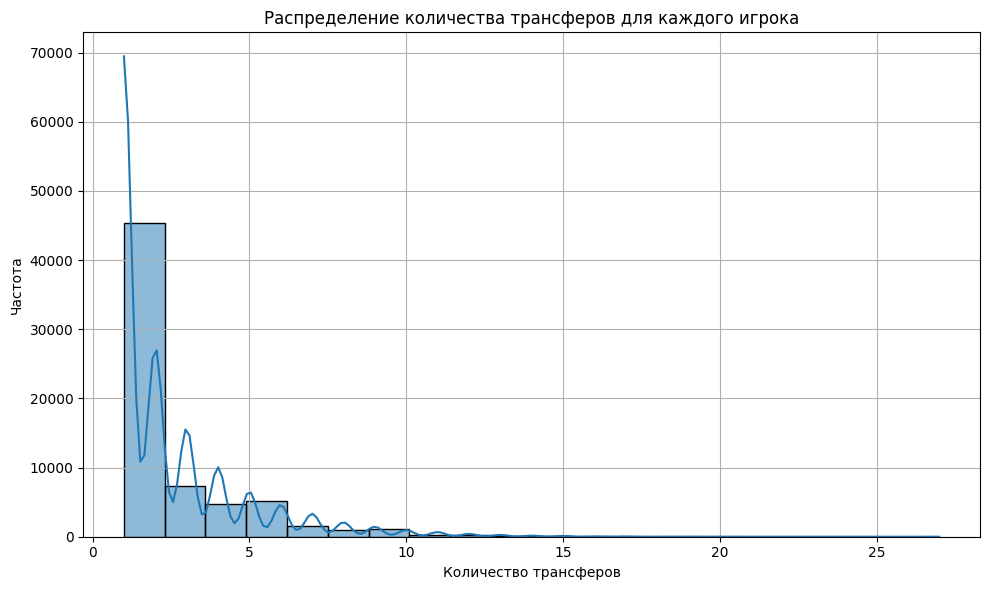

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(data=transfers.groupby('Player_id')['Date'].count().to_frame().sort_values(by='Date', ascending=False),
             x='Date',
             bins=20,
             kde=True)
plt.xlabel('Количество трансферов')
plt.ylabel('Частота')
plt.title('Распределение количества трансферов для каждого игрока')
plt.grid(True)
plt.tight_layout()
plt.show()

Посмотрим, кто совершил больше всего переходов:

In [45]:
transfers[transfers['Player_id'] == '54887'].sort_values(by='Date')

Player Player_id       Date From_team From_team_id  \
128826  Jay Stevens     54887 2012-03-09   No team          NaN   
128827  Jay Stevens     54887 2012-11-30   No team          NaN   
128828  Jay Stevens     54887 2012-12-14   No team          NaN   
128829  Jay Stevens     54887 2013-01-11   No team          NaN   
128830  Jay Stevens     54887 2013-03-06   No team          NaN   
128831  Jay Stevens     54887 2013-11-26   No team          NaN   
128832  Jay Stevens     54887 2013-12-03   No team          NaN   
128833  Jay Stevens     54887 2013-12-07   No team          NaN   
128834  Jay Stevens     54887 2013-12-11   No team          NaN   
128835  Jay Stevens     54887 2013-12-16   No team          NaN   
128836  Jay Stevens     54887 2014-01-08   No team          NaN   
128837  Jay Stevens     54887 2014-02-20   No team          NaN   
128838  Jay Stevens     54887 2015-03-03   No team          NaN   
128839  Jay Stevens     54887 2016-11-20   No team          NaN   
128840  Jay Stevens     54887 2016-12-10   No team          NaN   
128841  Jay Stevens     54887 2016-12-15   No team          NaN   
128842  Jay Stevens     54887 2017-02-28   No team          NaN   
128843  Jay Stevens     54887 2018-01-15   No team          NaN   
128844  Jay Stevens     54887 2018-03-10   No team          NaN   
128845  Jay Stevens     54887 2019-01-02   No team          NaN   
128846  Jay Stevens     54887 2021-01-15   No team          NaN   
128847  Jay Stevens     54887 2021-02-13   No team          NaN   
128848  Jay Stevens     54887 2021-04-17   No team          NaN   
128849  Jay Stevens     54887 2022-03-26   No team          NaN   
128850  Jay Stevens     54887 2022-03-30   No team          NaN   
128851  Jay Stevens     54887 2022-12-30   No team          NaN   
128852  Jay Stevens     54887 2023-02-22   No team          NaN   

                      To_team To_team_id  
128826          Ontario Reign       2694  
128827         Utah Grizzlies        105  
128828         Utah Grizzlies        105  
128829         Utah Grizzlies        105  
128830         Utah Grizzlies        105  
128831         Utah Grizzlies        105  
128832            Alaska Aces        674  
128833         Utah Grizzlies        105  
128834         Utah Grizzlies        105  
128835         Utah Grizzlies        105  
128836       Stockton Thunder       1429  
128837         Utah Grizzlies        105  
128838       Stockton Thunder       1429  
128839     Adirondack Thunder      18535  
128840         Utah Grizzlies        105  
128841         Toledo Walleye       4517  
128842            Alaska Aces        674  
128843         Utah Grizzlies        105  
128844         Utah Grizzlies        105  
128845         Utah Grizzlies        105  
128846  Kansas City Mavericks       4800  
128847        Wichita Thunder        836  
128848  Kansas City Mavericks       4800  
128849           Tulsa Oilers        721  
128850        Rapid City Rush       2707  
128851         Utah Grizzlies        105  
128852         Utah Grizzlies        105

In [46]:
transfers[transfers['Player_id'] == '57649'].sort_values(by='Date')

Player Player_id       Date From_team From_team_id  \
132710  Doug Melvin     57649 2012-11-20   No team          NaN   
132711  Doug Melvin     57649 2013-02-06   No team          NaN   
132712  Doug Melvin     57649 2013-02-21   No team          NaN   
132713  Doug Melvin     57649 2013-03-19   No team          NaN   
132714  Doug Melvin     57649 2013-10-12   No team          NaN   
132715  Doug Melvin     57649 2013-10-28   No team          NaN   
132716  Doug Melvin     57649 2013-11-08   No team          NaN   
132717  Doug Melvin     57649 2014-01-08   No team          NaN   
132718  Doug Melvin     57649 2014-02-22   No team          NaN   
132719  Doug Melvin     57649 2014-03-10   No team          NaN   
132720  Doug Melvin     57649 2014-12-03   No team          NaN   
132721  Doug Melvin     57649 2015-02-03   No team          NaN   
132722  Doug Melvin     57649 2015-03-05   No team          NaN   
132723  Doug Melvin     57649 2015-11-08   No team          NaN   
132724  Doug Melvin     57649 2016-12-15   No team          NaN   
132725  Doug Melvin     57649 2017-11-23   No team          NaN   
132726  Doug Melvin     57649 2018-01-13   No team          NaN   
132727  Doug Melvin     57649 2018-02-03   No team          NaN   
132728  Doug Melvin     57649 2018-02-14   No team          NaN   
132729  Doug Melvin     57649 2018-03-20   No team          NaN   
132730  Doug Melvin     57649 2019-11-21   No team          NaN   
132731  Doug Melvin     57649 2020-02-18   No team          NaN   
132732  Doug Melvin     57649 2021-12-10   No team          NaN   
132733  Doug Melvin     57649 2021-12-15   No team          NaN   
132734  Doug Melvin     57649 2022-11-23   No team          NaN   
132735  Doug Melvin     57649 2023-01-28   No team          NaN   
132736  Doug Melvin     57649 2023-02-10   No team          NaN   

                 To_team To_team_id  
132710  Idaho Steelheads        695  
132711    Utah Grizzlies        105  
132712  Idaho Steelheads        695  
132713  Idaho Steelheads        695  
132714  Idaho Steelheads        695  
132715  Idaho Steelheads        695  
132716       Alaska Aces        674  
132717  Idaho Steelheads        695  
132718    Utah Grizzlies        105  
132719  Idaho Steelheads        695  
132720  Idaho Steelheads        695  
132721  Idaho Steelheads        695  
132722  Stockton Thunder       1429  
132723  Idaho Steelheads        695  
132724  Idaho Steelheads        695  
132725  Idaho Steelheads        695  
132726  Idaho Steelheads        695  
132727  Idaho Steelheads        695  
132728  Idaho Steelheads        695  
132729  Idaho Steelheads        695  
132730  Idaho Steelheads        695  
132731  Idaho Steelheads        695  
132732  Idaho Steelheads        695  
132733  Idaho Steelheads        695  
132734   Allen Americans       4558  
132735   Wichita Thunder        836  
132736      Tulsa Oilers        721

Посмотрим на переходы Николая Лемтюгова:

In [47]:
transfers[transfers['Player_id'] == '9263'].sort_values(by='Date')

Player Player_id       Date                From_team  \
160816  Nikolai Lemtyugov      9263 2010-01-14    Severstal Cherepovets   
160817  Nikolai Lemtyugov      9263 2011-11-04            Ak Bars Kazan   
160818  Nikolai Lemtyugov      9263 2011-12-30   Metallurg Magnitogorsk   
160819  Nikolai Lemtyugov      9263 2012-05-29  Neftekhimik Nizhnekamsk   
160820  Nikolai Lemtyugov      9263 2012-12-29         Atlant Mytishchi   
160821  Nikolai Lemtyugov      9263 2013-05-22      Traktor Chelyabinsk   
160822  Nikolai Lemtyugov      9263 2013-12-09        Sibir Novosibirsk   
160823  Nikolai Lemtyugov      9263 2014-07-11           Spartak Moskva   
160824  Nikolai Lemtyugov      9263 2014-12-25            Avangard Omsk   
160825  Nikolai Lemtyugov      9263 2015-07-10    Yugra Khanty-Mansiysk   
160826  Nikolai Lemtyugov      9263 2018-10-17            Avangard Omsk   
160827  Nikolai Lemtyugov      9263 2018-12-22         Medvescak Zagreb   
160828  Nikolai Lemtyugov      9263 2019-07-01             Anyang Halla   

       From_team_id                  To_team To_team_id  
160816          198            Ak Bars Kazan        184  
160817          184   Metallurg Magnitogorsk        193  
160818          193  Neftekhimik Nizhnekamsk        196  
160819          196         Atlant Mytishchi       1572  
160820         1572      Traktor Chelyabinsk       1679  
160821         1679        Sibir Novosibirsk       1003  
160822         1003           Spartak Moskva        775  
160823          775            Avangard Omsk        186  
160824          186    Yugra Khanty-Mansiysk       2870  
160825         2870            Avangard Omsk        186  
160826          186         Medvescak Zagreb       1150  
160827         1150             Anyang Halla       1497  
160828         1497       Sheffield Steelers        210

### Сокращение датасета с трансферами по лиге КХЛ

#### Соращение по списку команд из КХЛ

В датасете с трансферами представлены все игроки из всех лиг, нам нужно оставить только КХЛ.

In [48]:
transfers['From_team_id'].nunique()

6771

In [49]:
transfers['To_team_id'].nunique()

3871

Список уникальных команд получили из датасета с игроками:

In [50]:
team_list_from_players_data = players_data['Team'].unique().tolist()

In [51]:
len(players_data['Team'].unique().tolist())

40

In [52]:
transfers_full = transfers.copy()

In [53]:
transfers = transfers[
    (transfers['From_team'].isin(team_list_from_players_data)) |
     (transfers['To_team'].isin(team_list_from_players_data))].reset_index(drop=True)

In [54]:
transfers

Player Player_id       Date                From_team  \
0       Rihards Marenis    100115 2018-10-11                  HK Mogo   
1       Rihards Marenis    100115 2019-03-06              Dinamo Riga   
2       Rihards Marenis    100115 2020-09-01              Dinamo Riga   
3      Maksim Matushkin     10016 2018-05-01                    Ässät   
4      Maksim Matushkin     10016 2020-11-12   Metallurg Magnitogorsk   
...                 ...       ...        ...                      ...   
10270    Ilya Nekolenko     99696 2018-09-04  Neftekhimik Nizhnekamsk   
10271     Pavel Shegalo     99708 2016-05-28        Metallurg Zhlobin   
10272     Pavel Shegalo     99708 2016-10-24        Sibir Novosibirsk   
10273  Dennis Rasmussen      9985 2018-06-01          Växjö Lakers HC   
10274  Dennis Rasmussen      9985 2021-06-03   Metallurg Magnitogorsk   

      From_team_id                 To_team To_team_id  
0             5067             Dinamo Riga        673  
1              673                 HK Mogo       5067  
2              673                 HK Mogo       5067  
3               49  Metallurg Magnitogorsk        193  
4              193   Severstal Cherepovets        198  
...            ...                     ...        ...  
10270          196          Reading Royals        639  
10271         2365       Sibir Novosibirsk       1003  
10272         1003                 Unknown        NaN  
10273          339  Metallurg Magnitogorsk        193  
10274          193                HC Davos        110  

[10275 rows x 7 columns]

Количество уникальных игроков было сокращено:

In [55]:
transfers['Player_id'].nunique()

3583

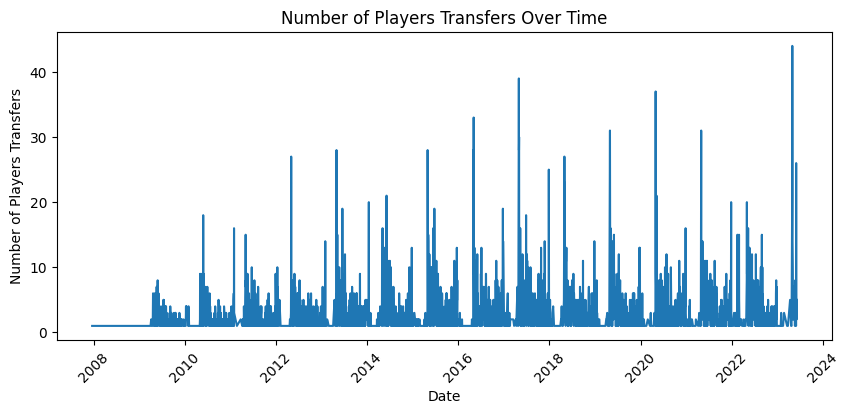

In [56]:
plt.figure(figsize=(10, 4))
#sns.set_style('whitegrid')
sns.lineplot(x='Date', y='Player_id', data=transfers.groupby('Date')['Player_id'].count().reset_index())
plt.xticks(rotation=45)

plt.title('Number of Players Transfers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Players Transfers')
plt.show()

#### Проверка на то, был ли игрок когда либо в КХЛ

А что если игрок был в КХЛ, а потом переходил в команды других лиг?

In [57]:
# создадим список с уникальными ID игроков
player_ids = transfers_full['Player_id'].unique()

In [58]:
len(player_ids)

67158

In [59]:
# пустой список для записи результата
#result_list = []

# итерируемся по каждому id игрока
#for player_id in player_ids:
    # отфильтруем срез данных по каждому id игрока
    #player_transfers = transfers_full[transfers_full['Player_id'] == player_id]

    # проверим, есть ли хотя бы один трансфер в/ из команды из КХЛ из списка team_list_from_players_data
    #has_team_in_list = (player_transfers['From_team'].isin(team_list_from_players_data).any()) or (player_transfers['To_team'].isin(team_list_from_players_data).any())

    # результат проверки добавим в заранее созданный список result_list
    #result_list.append((player_id, has_team_in_list))

# создадим итоговый датафрейм
#result_df = pd.DataFrame(result_list, columns=['Player_id', 'Has_team_in_list'])

Повышение производительности:

In [60]:
# проверка количества ядер у Гугл Колаб
num_cpu_cores = os.cpu_count()
print("Number of CPU cores:", num_cpu_cores)

Number of CPU cores: 2


In [61]:
# функция на основе цикла, который выше:
def check_teams_for_players(start_index, end_index):
    for player_id in player_ids[start_index:end_index]:
        player_transfers = transfers_full[transfers_full['Player_id'] == player_id]

        has_team_in_list = (player_transfers['From_team'].isin(team_list_from_players_data).any()) or (player_transfers['To_team'].isin(team_list_from_players_data).any())

        result_list.append((player_id, has_team_in_list))

In [62]:
transfers_full[
    ((transfers_full['From_team'].isin(team_list_from_players_data) | transfers_full['To_team'].isin(team_list_from_players_data))) &
     (~transfers_full['From_team'].isin(team_list_from_players_data) |(~transfers_full['To_team'].isin(team_list_from_players_data)))].reset_index(drop=True)

Player Player_id       Date                From_team  \
0      Rihards Marenis    100115 2018-10-11                  HK Mogo   
1      Rihards Marenis    100115 2019-03-06              Dinamo Riga   
2      Rihards Marenis    100115 2020-09-01              Dinamo Riga   
3     Maksim Matushkin     10016 2018-05-01                    Ässät   
4     Maksim Matushkin     10016 2021-01-23       SKA St. Petersburg   
...                ...       ...        ...                      ...   
6003    Ilya Nekolenko     99696 2018-09-04  Neftekhimik Nizhnekamsk   
6004     Pavel Shegalo     99708 2016-05-28        Metallurg Zhlobin   
6005     Pavel Shegalo     99708 2016-10-24        Sibir Novosibirsk   
6006  Dennis Rasmussen      9985 2018-06-01          Växjö Lakers HC   
6007  Dennis Rasmussen      9985 2021-06-03   Metallurg Magnitogorsk   

     From_team_id                 To_team To_team_id  
0            5067             Dinamo Riga        673  
1             673                 HK Mogo       5067  
2             673                 HK Mogo       5067  
3              49  Metallurg Magnitogorsk        193  
4             199                 Tappara         47  
...           ...                     ...        ...  
6003          196          Reading Royals        639  
6004         2365       Sibir Novosibirsk       1003  
6005         1003                 Unknown        NaN  
6006          339  Metallurg Magnitogorsk        193  
6007          193                HC Davos        110  

[6008 rows x 7 columns]

In [63]:
# сократили список, чтобы было меньше итеграций:
player_ids = player_ids[:100]

In [64]:
# Пустой список для записи результата
result_list = []

In [65]:
# Разделим player_ids на две части для двух потоков
mid_index = len(player_ids) // 2

In [66]:
# Создадим список для хранения потоков
threads = []

# Создадим два потока
thread1 = threading.Thread(target=check_teams_for_players, args=(0, mid_index))
thread2 = threading.Thread(target=check_teams_for_players, args=(mid_index, len(player_ids)))

# Запустим потоки
thread1.start()
thread2.start()

# Дождемся окончания работы потоков
thread1.join()
thread2.join()

# Создадим итоговый датафрейм
result_df = pd.DataFrame(result_list, columns=['Player_id', 'Has_team_in_list'])

In [67]:
result_df

Player_id  Has_team_in_list
0     100305             False
1        100             False
2     100308             False
3     100311             False
4      10001             False
..       ...               ...
95    100479              True
96     10048             False
97    100494             False
98     10050             False
99     10051             False

[100 rows x 2 columns]

In [68]:
result_df['Has_team_in_list'].unique()

array([False,  True])

In [69]:
result_df['Has_team_in_list'].value_counts()

False    91
True      9
Name: Has_team_in_list, dtype: int64

В итоге мы для каждого id игрока получаем значение True/ False, можем понять, было ли взаимодействие игрока с КЛХ.

In [70]:
cProfile.run("check_teams_for_players(0, mid_index); check_teams_for_players(mid_index, len(player_ids))")

         141064 function calls (138626 primitive calls) in 3.450 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.001    0.000    0.001    0.000 <frozen importlib._bootstrap>:1053(_handle_fromlist)
        2    0.006    0.003    3.450    1.725 <ipython-input-61-6ceaaefbfce6>:2(check_teams_for_players)
        1    0.000    0.000    3.450    3.450 <string>:1(<module>)
      192    0.001    0.000    0.025    0.000 _decorators.py:323(wrapper)
      192    0.000    0.000    0.000    0.000 _dtype.py:24(_kind_name)
      192    0.000    0.000    0.000    0.000 _dtype.py:330(_name_includes_bit_suffix)
      192    0.001    0.000    0.002    0.000 _dtype.py:344(_name_get)
      100    0.000    0.000    0.000    0.000 _methods.py:38(_amax)
      100    0.000    0.000    0.001    0.000 _methods.py:42(_amin)
      392    0.000    0.000    0.005    0.000 _methods.py:54(_any)
      100    0.001    0.000    0.013    0.000 _

In [71]:
#Код ревьюера - смотрим, кто из КХЛ ушел в дргую лигу или кто из других лиг пришел в КХЛ
transfers_full[
    ((transfers_full['From_team'].isin(team_list_from_players_data) | transfers_full['To_team'].isin(team_list_from_players_data))) &
     (~transfers_full['From_team'].isin(team_list_from_players_data) |(~transfers_full['To_team'].isin(team_list_from_players_data)))].reset_index(drop=True)

Player Player_id       Date                From_team  \
0      Rihards Marenis    100115 2018-10-11                  HK Mogo   
1      Rihards Marenis    100115 2019-03-06              Dinamo Riga   
2      Rihards Marenis    100115 2020-09-01              Dinamo Riga   
3     Maksim Matushkin     10016 2018-05-01                    Ässät   
4     Maksim Matushkin     10016 2021-01-23       SKA St. Petersburg   
...                ...       ...        ...                      ...   
6003    Ilya Nekolenko     99696 2018-09-04  Neftekhimik Nizhnekamsk   
6004     Pavel Shegalo     99708 2016-05-28        Metallurg Zhlobin   
6005     Pavel Shegalo     99708 2016-10-24        Sibir Novosibirsk   
6006  Dennis Rasmussen      9985 2018-06-01          Växjö Lakers HC   
6007  Dennis Rasmussen      9985 2021-06-03   Metallurg Magnitogorsk   

     From_team_id                 To_team To_team_id  
0            5067             Dinamo Riga        673  
1             673                 HK Mogo       5067  
2             673                 HK Mogo       5067  
3              49  Metallurg Magnitogorsk        193  
4             199                 Tappara         47  
...           ...                     ...        ...  
6003          196          Reading Royals        639  
6004         2365       Sibir Novosibirsk       1003  
6005         1003                 Unknown        NaN  
6006          339  Metallurg Magnitogorsk        193  
6007          193                HC Davos        110  

[6008 rows x 7 columns]

Дальше мы хотим по каждому игроку для каждой команды получить дату начала и конца игры в каждой команде.

#### Даты начала и конца игры в команде

In [72]:
transfers.sample(5)

Player Player_id       Date                   From_team  \
8546     Kirill Dyakov     77147 2016-10-27      Metallurg Novokuznetsk   
6644     Vadim Antipin    392063 2022-08-17      Metallurg Magnitogorsk   
8510      Vitali Popov     77114 2016-09-09  Avtomobilist Yekaterinburg   
3785  Yevgeni Skachkov     19596 2017-05-03                    HK Sochi   
1313      Ivan Kasutin     12244 2011-05-11     Neftekhimik Nizhnekamsk   

     From_team_id                  To_team To_team_id  
8546          194  Neftekhimik Nizhnekamsk        196  
6644          193    Yugra Khanty-Mansiysk       2870  
8510         1724          Amur Khabarovsk        185  
3785        17166    Yugra Khanty-Mansiysk       2870  
1313          196           Spartak Moskva        775

In [73]:
unique_player_id = transfers['Player_id'].unique().tolist()

In [74]:
len(unique_player_id)

3583

##### Получение дат с помощью метода shift()

Сначала получим срез данных по игроку.

In [75]:
draft = transfers[transfers['Player'] == 'Nikolai Lemtyugov'].reset_index(drop=True)
draft

Player Player_id       Date                From_team  \
0   Nikolai Lemtyugov      9263 2010-01-14    Severstal Cherepovets   
1   Nikolai Lemtyugov      9263 2011-11-04            Ak Bars Kazan   
2   Nikolai Lemtyugov      9263 2011-12-30   Metallurg Magnitogorsk   
3   Nikolai Lemtyugov      9263 2012-05-29  Neftekhimik Nizhnekamsk   
4   Nikolai Lemtyugov      9263 2012-12-29         Atlant Mytishchi   
5   Nikolai Lemtyugov      9263 2013-05-22      Traktor Chelyabinsk   
6   Nikolai Lemtyugov      9263 2013-12-09        Sibir Novosibirsk   
7   Nikolai Lemtyugov      9263 2014-07-11           Spartak Moskva   
8   Nikolai Lemtyugov      9263 2014-12-25            Avangard Omsk   
9   Nikolai Lemtyugov      9263 2015-07-10    Yugra Khanty-Mansiysk   
10  Nikolai Lemtyugov      9263 2018-10-17            Avangard Omsk   
11  Nikolai Lemtyugov      9263 2018-12-22         Medvescak Zagreb   

   From_team_id                  To_team To_team_id  
0           198            Ak Bars Kazan        184  
1           184   Metallurg Magnitogorsk        193  
2           193  Neftekhimik Nizhnekamsk        196  
3           196         Atlant Mytishchi       1572  
4          1572      Traktor Chelyabinsk       1679  
5          1679        Sibir Novosibirsk       1003  
6          1003           Spartak Moskva        775  
7           775            Avangard Omsk        186  
8           186    Yugra Khanty-Mansiysk       2870  
9          2870            Avangard Omsk        186  
10          186         Medvescak Zagreb       1150  
11         1150             Anyang Halla       1497

Создадим дубликат последней строки. Это нужно при использовании shift(periods=1).

In [76]:
# Получаем последнюю строку датафрейма
last_row = draft.iloc[-1:]

In [77]:
# Создаем дубликат последней строки
duplicate_last_row = last_row.copy()

In [78]:
duplicate_last_row

Player Player_id       Date         From_team From_team_id  \
11  Nikolai Lemtyugov      9263 2018-12-22  Medvescak Zagreb         1150   

         To_team To_team_id  
11  Anyang Halla       1497

Из столбца From_team будет формироваться итоговый столбик Team.

In [79]:
duplicate_last_row['From_team'] = duplicate_last_row['To_team']
duplicate_last_row['From_team_id'] = duplicate_last_row['To_team_id']
duplicate_last_row['Date'] = None

In [80]:
duplicate_last_row

Player Player_id  Date     From_team From_team_id  \
11  Nikolai Lemtyugov      9263  None  Anyang Halla         1497   

         To_team To_team_id  
11  Anyang Halla       1497

In [81]:
draft = draft.append(duplicate_last_row, ignore_index=True)

Используем метод shift() для получения даты старта игры в команде.

In [82]:
draft['Date_Start'] = draft['Date'].shift(periods=1)

Перегруппируем столбики в более удобном порядке:

In [83]:
draft = draft[['Player', 'Player_id', 'From_team', 'From_team_id', 'Date_Start', 'Date']]

Переименуем столбцы. Столбик "Date" является теперь датой завершения игры в команде.

In [84]:
draft = draft.rename(columns={'From_team': 'Team', 'From_team_id': 'Team_Id', 'Date': 'Date_End'})

In [85]:
draft

Player Player_id                     Team Team_Id Date_Start  \
0   Nikolai Lemtyugov      9263    Severstal Cherepovets     198        NaT   
1   Nikolai Lemtyugov      9263            Ak Bars Kazan     184 2010-01-14   
2   Nikolai Lemtyugov      9263   Metallurg Magnitogorsk     193 2011-11-04   
3   Nikolai Lemtyugov      9263  Neftekhimik Nizhnekamsk     196 2011-12-30   
4   Nikolai Lemtyugov      9263         Atlant Mytishchi    1572 2012-05-29   
5   Nikolai Lemtyugov      9263      Traktor Chelyabinsk    1679 2012-12-29   
6   Nikolai Lemtyugov      9263        Sibir Novosibirsk    1003 2013-05-22   
7   Nikolai Lemtyugov      9263           Spartak Moskva     775 2013-12-09   
8   Nikolai Lemtyugov      9263            Avangard Omsk     186 2014-07-11   
9   Nikolai Lemtyugov      9263    Yugra Khanty-Mansiysk    2870 2014-12-25   
10  Nikolai Lemtyugov      9263            Avangard Omsk     186 2015-07-10   
11  Nikolai Lemtyugov      9263         Medvescak Zagreb    1150 2018-10-17   
12  Nikolai Lemtyugov      9263             Anyang Halla    1497 2018-12-22   

     Date_End  
0  2010-01-14  
1  2011-11-04  
2  2011-12-30  
3  2012-05-29  
4  2012-12-29  
5  2013-05-22  
6  2013-12-09  
7  2014-07-11  
8  2014-12-25  
9  2015-07-10  
10 2018-10-17  
11 2018-12-22  
12        NaT

В итоге мы получили дату начала и дату конца игры по командам.

##### Получение дат с помощью метода shift() для всех игроков

С помощью описанной логики заполним даты для всех игроков.

In [86]:
dataframes_dict = {}

In [87]:
for player_id in unique_player_id:
    # получаем срез данных по каждому игроку
    transfers_by_player = transfers[transfers['Player_id'] == player_id].sort_values(by="Date")

    # Получаем последнюю строку датафрейма
    last_row = transfers_by_player.iloc[-1:]
    # Создаем дубликат последней строки
    duplicate_last_row = last_row.copy()
    # заменяем значения
    duplicate_last_row['From_team'] = duplicate_last_row['To_team']
    duplicate_last_row['From_team_id'] = duplicate_last_row['To_team_id']
    duplicate_last_row['Date'] = None

    # добавляем дубликат строки с измененными значеними в срез данных
    transfers_by_player = transfers_by_player.append(duplicate_last_row, ignore_index=True)

    #используем метод shift()
    transfers_by_player['Date_Start'] = transfers_by_player['Date'].shift(periods=1)
    transfers_by_player = transfers_by_player[['Player', 'Player_id', 'From_team', 'From_team_id', 'Date_Start', 'Date']]
    transfers_by_player = transfers_by_player.rename(columns={'From_team': 'Team', 'From_team_id': 'Team_Id', 'Date': 'Date_End'})

    # Имя датафрейма, которое содержит player_id
    dataframe_name = 'transfers_' + str(player_id)
    # Добавляем полученный срез данных в словарь с указанием имени датафрейма
    dataframes_dict[dataframe_name] = transfers_by_player

In [88]:
dataframes_dict['transfers_9263']

Player Player_id                     Team Team_Id Date_Start  \
0   Nikolai Lemtyugov      9263    Severstal Cherepovets     198        NaT   
1   Nikolai Lemtyugov      9263            Ak Bars Kazan     184 2010-01-14   
2   Nikolai Lemtyugov      9263   Metallurg Magnitogorsk     193 2011-11-04   
3   Nikolai Lemtyugov      9263  Neftekhimik Nizhnekamsk     196 2011-12-30   
4   Nikolai Lemtyugov      9263         Atlant Mytishchi    1572 2012-05-29   
5   Nikolai Lemtyugov      9263      Traktor Chelyabinsk    1679 2012-12-29   
6   Nikolai Lemtyugov      9263        Sibir Novosibirsk    1003 2013-05-22   
7   Nikolai Lemtyugov      9263           Spartak Moskva     775 2013-12-09   
8   Nikolai Lemtyugov      9263            Avangard Omsk     186 2014-07-11   
9   Nikolai Lemtyugov      9263    Yugra Khanty-Mansiysk    2870 2014-12-25   
10  Nikolai Lemtyugov      9263            Avangard Omsk     186 2015-07-10   
11  Nikolai Lemtyugov      9263         Medvescak Zagreb    1150 2018-10-17   
12  Nikolai Lemtyugov      9263             Anyang Halla    1497 2018-12-22   

     Date_End  
0  2010-01-14  
1  2011-11-04  
2  2011-12-30  
3  2012-05-29  
4  2012-12-29  
5  2013-05-22  
6  2013-12-09  
7  2014-07-11  
8  2014-12-25  
9  2015-07-10  
10 2018-10-17  
11 2018-12-22  
12        NaT

In [89]:
len(dataframes_dict)

3583

In [90]:
transfers_all_dataframes = pd.concat(dataframes_dict.values(), ignore_index=True)

In [91]:
transfers_all_dataframes

Player Player_id                    Team Team_Id Date_Start  \
0       Rihards Marenis    100115                 HK Mogo    5067        NaT   
1       Rihards Marenis    100115             Dinamo Riga     673 2018-10-11   
2       Rihards Marenis    100115             Dinamo Riga     673 2019-03-06   
3       Rihards Marenis    100115                 HK Mogo    5067 2020-09-01   
4      Maksim Matushkin     10016                   Ässät      49        NaT   
...                 ...       ...                     ...     ...        ...   
13853     Pavel Shegalo     99708       Sibir Novosibirsk    1003 2016-05-28   
13854     Pavel Shegalo     99708                 Unknown     NaN 2016-10-24   
13855  Dennis Rasmussen      9985         Växjö Lakers HC     339        NaT   
13856  Dennis Rasmussen      9985  Metallurg Magnitogorsk     193 2018-06-01   
13857  Dennis Rasmussen      9985                HC Davos     110 2021-06-03   

        Date_End  
0     2018-10-11  
1     2019-03-06  
2     2020-09-01  
3            NaT  
4     2018-05-01  
...          ...  
13853 2016-10-24  
13854        NaT  
13855 2018-06-01  
13856 2021-06-03  
13857        NaT  

[13858 rows x 6 columns]

In [92]:
transfers_all_dataframes[transfers_all_dataframes['Player_id'] == '9263']

Player Player_id                     Team Team_Id  \
12867  Nikolai Lemtyugov      9263    Severstal Cherepovets     198   
12868  Nikolai Lemtyugov      9263            Ak Bars Kazan     184   
12869  Nikolai Lemtyugov      9263   Metallurg Magnitogorsk     193   
12870  Nikolai Lemtyugov      9263  Neftekhimik Nizhnekamsk     196   
12871  Nikolai Lemtyugov      9263         Atlant Mytishchi    1572   
12872  Nikolai Lemtyugov      9263      Traktor Chelyabinsk    1679   
12873  Nikolai Lemtyugov      9263        Sibir Novosibirsk    1003   
12874  Nikolai Lemtyugov      9263           Spartak Moskva     775   
12875  Nikolai Lemtyugov      9263            Avangard Omsk     186   
12876  Nikolai Lemtyugov      9263    Yugra Khanty-Mansiysk    2870   
12877  Nikolai Lemtyugov      9263            Avangard Omsk     186   
12878  Nikolai Lemtyugov      9263         Medvescak Zagreb    1150   
12879  Nikolai Lemtyugov      9263             Anyang Halla    1497   

      Date_Start   Date_End  
12867        NaT 2010-01-14  
12868 2010-01-14 2011-11-04  
12869 2011-11-04 2011-12-30  
12870 2011-12-30 2012-05-29  
12871 2012-05-29 2012-12-29  
12872 2012-12-29 2013-05-22  
12873 2013-05-22 2013-12-09  
12874 2013-12-09 2014-07-11  
12875 2014-07-11 2014-12-25  
12876 2014-12-25 2015-07-10  
12877 2015-07-10 2018-10-17  
12878 2018-10-17 2018-12-22  
12879 2018-12-22        NaT

In [93]:
fig = px.timeline(transfers_all_dataframes[transfers_all_dataframes['Player_id'] == '9263'],
                  x_start="Date_Start",
                  x_end="Date_End",
                  y="Team",
                  color="Team",
                 title = 'Команды, в которых играл Николай Лемтюгов по годам')
#fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

## Внешний датасет с игроками

In [94]:
players = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/e/2PACX-1vT3TtrPT83dPIbAEtp5tjhpHmllTxYjFhJ62lThCeI9yPMeYwMCHPq9J5uoAL-Zcx3HvxMlXEeEl8iT/pub?output=csv'
)

In [95]:
players.head()

player_link  \
0  https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
1  https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
2  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
3  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
4  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   

               player          team   start_date     end_date  
0  Juhamatti Aaltonen       Jokerit   4 Sep 2014   2 Mar 2016  
1  Juhamatti Aaltonen  Metallurg Mg   9 Sep 2010  22 Mar 2012  
2       Miro Aaltonen        Vityaz   2 Sep 2021  11 Jan 2022  
3       Miro Aaltonen           SKA  17 Dec 2019  27 Feb 2021  
4       Miro Aaltonen        Vityaz  27 Aug 2016   9 Dec 2019

In [96]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8179 entries, 0 to 8178
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player_link  8179 non-null   object
 1   player       8179 non-null   object
 2   team         8179 non-null   object
 3   start_date   8179 non-null   object
 4   end_date     8179 non-null   object
dtypes: object(5)
memory usage: 319.6+ KB


### Предобработка

Приведем тип данных в столбцах start_date, end_date к нужному типу:

In [97]:
players['start_date'] = pd.to_datetime(players['start_date'], format='%d %b %Y')
players['end_date'] = pd.to_datetime(players['end_date'], format='%d %b %Y')

Получим id игрока:

In [98]:
players['player_id'] = players['player_link'].str.split('/').str[-2]

In [99]:
players = players.drop('player_link', axis=1)

In [100]:
players = players[['player', 'player_id', 'team', 'start_date', 'end_date']]

In [101]:
players.head()

player player_id          team start_date   end_date
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09

In [102]:
!ls

drive  players.csv  sample_data


In [103]:
directory = '/content/drive/MyDrive'
os.makedirs(directory, exist_ok=True)

In [104]:
#players.to_csv('/content/drive/MyDrive/players.csv', index=False)
players.to_csv('/content/players.csv', index=False)

In [105]:
%pwd

'/content'

In [106]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/players.csv'

# Сохранение датафрейма в CSV-файле
#players.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

Посмотрим количество уникальных игроков и количество уникальных команд:

In [107]:
players['player_id'].nunique()

3720

In [108]:
players['team'].nunique()

38

Посмотрим, сколько уникальных игроков было в той или иной команде:

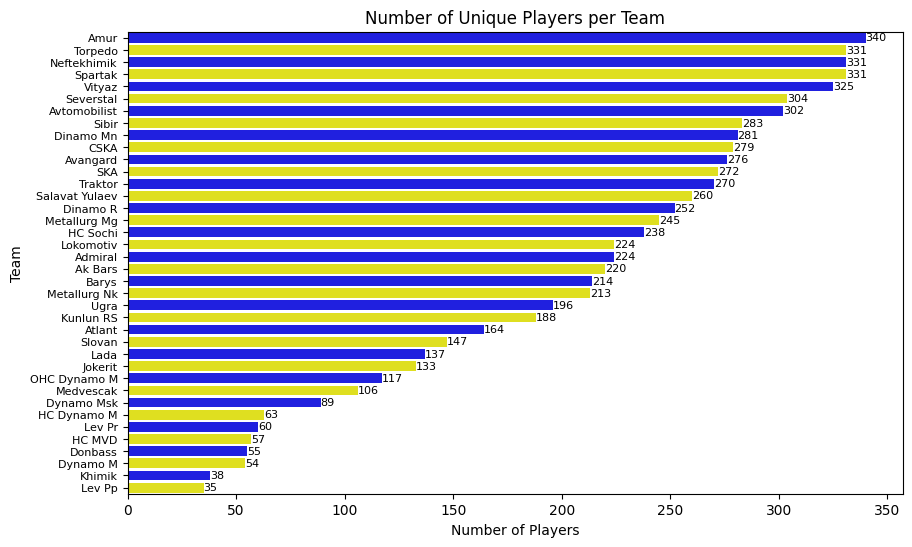

In [109]:
grouped_players = players.groupby('team')['player_id'].agg('nunique')
grouped_players = grouped_players.sort_values(ascending=False)
custom_palette = ['blue', 'yellow']

plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_players.values, y=grouped_players.index, palette=custom_palette)

plt.xlabel('Number of Players')
plt.ylabel('Team')
plt.title('Number of Unique Players per Team')

plt.tick_params(axis='y', labelsize=8)

for index, value in enumerate(grouped_players.values):
    plt.text(value, index, str(value), va='center', fontsize=8)

plt.show()

Больше всего игроков было в команде Amur(340), меньше всего - в Lev Pp.

### Словарь player_id, player

In [110]:
players.head()

player player_id          team start_date   end_date
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09

In [111]:
player_dict = players.set_index('player_id')['player'].to_dict()

In [112]:
def find_player_id_by_name(player_dict, player_name):
    """
    Функция находит player_id для имени игрока из словаря.

    Параметры:
        player_dict (dict): Название словаря.
        player_name (str): Имя игрока, id которого надо установить.

    Returns:
        int or None: Возращает id игрока или None
    """
    for player_id, name in player_dict.items():
        if name == player_name:
            return player_id
    return None

In [113]:
player_dict['13705']

'Nikolai Lemtyugov'

### ID Лемтюгова

In [114]:
find_player_id_by_name(player_dict, "Nikolai Lemtyugov")

'13705'

### Объединие датасета самого с собой для получения списка одноклубников

Объединяем датасет сам с собой по столбцу team - там как мы получим всех игроков, которые были в одной команде, включая самого игрока.

In [115]:
clubmates = players.merge(players, on='team', suffixes=('_player', '_clubmate'))

In [116]:
clubmates

player_player player_id_player     team start_date_player  \
0        Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
1        Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
2        Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
3        Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
4        Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
...                     ...              ...      ...               ...   
2185584       Martin Strbak             5454   Lev Pp        2011-09-12   
2185585       Martin Strbak             5454   Lev Pp        2011-09-12   
2185586       Martin Strbak             5454   Lev Pp        2011-09-12   
2185587       Martin Strbak             5454   Lev Pp        2011-09-12   
2185588       Martin Strbak             5454   Lev Pp        2011-09-12   

        end_date_player     player_clubmate player_id_clubmate  \
0            2016-03-02  Juhamatti Aaltonen              16785   
1            2016-03-02     Niclas Andersen              19127   
2            2016-03-02       Marko Anttila              20970   
3            2016-03-02      Semir Ben-Amor              22344   
4            2016-03-02    Hannes Bjorninen              33809   
...                 ...                 ...                ...   
2185584      2012-02-26     Jaroslav Sarsok              18008   
2185585      2012-02-26          Jiri Sekac              17885   
2185586      2012-02-26    Jonathan Sigalet              17930   
2185587      2012-02-26    Rastislav Spirko              17674   
2185588      2012-02-26       Martin Strbak               5454   

        start_date_clubmate end_date_clubmate  
0                2014-09-04        2016-03-02  
1                2017-11-17        2018-03-24  
2                2016-08-23        2022-01-05  
3                2014-09-04        2015-03-13  
4                2021-09-02        2022-01-11  
...                     ...               ...  
2185584          2012-01-31        2012-02-26  
2185585          2011-09-12        2012-02-26  
2185586          2011-09-12        2012-02-15  
2185587          2011-09-12        2012-02-26  
2185588          2011-09-12        2012-02-26  

[2185589 rows x 9 columns]

Фильтруем, чтобы оставить только строки с разными игроками, одной и той же командой. Также учтнем пересечение временных интервалов.

In [117]:
clubmates = clubmates[
    (clubmates['player_id_player'] != clubmates['player_id_clubmate']) &
    (clubmates['start_date_player'] <= clubmates['end_date_clubmate']) &
    (clubmates['start_date_clubmate'] <= clubmates['end_date_player'])
]

In [118]:
clubmates

player_player player_id_player     team start_date_player  \
3        Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
11       Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
12       Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
14       Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
15       Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
...                     ...              ...      ...               ...   
2185583       Martin Strbak             5454   Lev Pp        2011-09-12   
2185584       Martin Strbak             5454   Lev Pp        2011-09-12   
2185585       Martin Strbak             5454   Lev Pp        2011-09-12   
2185586       Martin Strbak             5454   Lev Pp        2011-09-12   
2185587       Martin Strbak             5454   Lev Pp        2011-09-12   

        end_date_player   player_clubmate player_id_clubmate  \
3            2016-03-02    Semir Ben-Amor              22344   
11           2016-03-02    Ryan Gunderson              22345   
12           2016-03-02       Frank Gymer              22372   
14           2016-03-02     Niklas Hagman              19382   
15           2016-03-02         Riku Hahl              22353   
...                 ...               ...                ...   
2185583      2012-02-26       Karel Pilar              15229   
2185584      2012-02-26   Jaroslav Sarsok              18008   
2185585      2012-02-26        Jiri Sekac              17885   
2185586      2012-02-26  Jonathan Sigalet              17930   
2185587      2012-02-26  Rastislav Spirko              17674   

        start_date_clubmate end_date_clubmate  
3                2014-09-04        2015-03-13  
11               2014-09-04        2015-03-19  
12               2015-11-29        2017-02-27  
14               2014-09-04        2016-03-02  
15               2014-09-04        2015-03-19  
...                     ...               ...  
2185583          2011-09-12        2012-01-28  
2185584          2012-01-31        2012-02-26  
2185585          2011-09-12        2012-02-26  
2185586          2011-09-12        2012-02-15  
2185587          2011-09-12        2012-02-26  

[417922 rows x 9 columns]

In [119]:
# Группировка данных для получения списка одноклубников для каждого игрока
grouped_clubmates = clubmates.groupby('player_player')['player_clubmate'].apply(list).reset_index()

# Переименование столбца
grouped_clubmates.rename(columns={'player_player': 'player', 'player_clubmate': 'clubmates'}, inplace=True)

In [120]:
grouped_clubmates

player  \
0       Aaron Palushaj   
1        Adam Almquist   
2       Adam Cracknell   
3         Adam Deutsch   
4         Adam Helewka   
...                ...   
3707       Zesen Zhang   
3708       Ziga Jeglic   
3709  Zigurds Podzinsh   
3710       Zimeng Chen   
3711      Ziyat Paigin   

                                                                                                                                                                                                    clubmates  
0     [Andrei Antonov, Ilya Arkalov, Gilbert Brule, Alexander Bumagin, Leonid Fomin, Artyom Gareyev, Anatoly Golyshev, Sergei V. Gusev, Roman Ivashov, Gleb Klimenko, Nikita G. Komarov, Jakub Kovar, Vikt...  
1     [Yegor Antropov, Zakhar Arzamastsev, Vadim Berdnikov, Pavel Buchnevich, Pavel Chernov, Pavel Dedunov, Dmitry Kagarlitsky, Stanislav Kalashnikov, Nikolai Kazakovtsev, Ilya Khokhlov, Evgeny Kovyrshi...  
2     [Victor Bartley, David Bondra, Gilbert Brule, Jake Chelios, Brandon DeFazio, Spencer Foo, Jason Fram, Simon Hrubec, Yang Hu, Garet Hunt, Brayden Jaw, Cory Kane, Lucas Lockhart, Sam Lofquist, Brand...  
3     [Ilya Arkalov, Patrick Bjorkstrand, Alexandre Bolduc, Gilbert Brule, Colby Genoway, Stefano Giliati, Mike Glumac, Simon Gysbers, Edwin Hedberg, Calvin Heeter, Andreas Jamtin, Ivan Jankovic, Milan ...  
4     [Pavel Akolzin, Alikhan Asetov, Jesse Blacker, Dustin Boyd, Samat Daniyar, Sayan Daniyar, Darren Dietz, Dmitry Grents, Dmitry Gurkov, Henrik Karlsson, Corban Knight, Sergei Kudryavtsev, Alexei Mak...  
...                                                                                                                                                                                                       ...  
3707  [Mikhail A. Abramov, Kristian Afanasyev, Victor Bartley, Devin Brosseau, Colin Campbell, Jake Chelios, Zimeng Chen, Parker Foo, Spencer Foo, Jason Fram, Matteo Gennaro, Jianing Guo, Pengfei Han, Y...  
3708  [Ilnur Abdulkhakov, Ilya Arkalov, Alexander Avtsin, Rafael Bikmullin, Alexander Bryntsev, Dennis Everberg, Ilya Ezhov, Kamil Fazylzyanov, Nikita Filatov, Emil Galimov, Erik Gustafsson, Robin Hanzl...  
3709  [Kirill Adamchuk, Rafael Akhmetov, Evgeny Alikin, Akim Aliu, Ilya Andryukhov, Vitaly Atyushov, Ruslan Bashkirov, Niclas Bergfors, Alexei Byvaltsev, Nikita Cherepanov, Pavel Dedunov, Alexander Deln...  
3710  [Mikhail A. Abramov, Kristian Afanasyev, Devin Brosseau, Colin Campbell, Jake Chelios, Parker Foo, Spencer Foo, Jason Fram, Matteo Gennaro, Jianing Guo, Pengfei Han, Garet Hunt, Colin Joe, Tomas J...  
3711  [Ilnur Abdulkhakov, Vitaly Atyushov, Alexander Avtsin, Konstantin Barulin, Jacob Berglund, Rafael Bikmullin, Alexander Bryntsev, Alexander M. Chernikov, Andrei Chivilyov, Jonas Enlund, Radel Fazle...  

[3712 rows x 2 columns]

In [121]:
clubmates_dataframe = clubmates.copy()

In [122]:
clubmates_base = clubmates.groupby('player_id_player')['player_id_clubmate'].apply(list).reset_index()
clubmates_base.rename(columns={'player_id_player': 'player_id', 'player_id_clubmate': 'clubmates_id'}, inplace=True)

In [123]:
clubmates_base

player_id  \
0            1   
1        10162   
2        10176   
3        10427   
4        10541   
...        ...   
3715      9859   
3716      9860   
3717      9862   
3718      9863   
3719        99   

                                                                                                                                                                                                 clubmates_id  
0     [13873, 13490, 9435, 13923, 15889, 16119, 19294, 17292, 3607, 16118, 22027, 3920, 13916, 13805, 3945, 14982, 14887, 15732, 15482, 21983, 3614, 17754, 21111, 4014, 15977, 17632, 6440, 19058, 3538, ...  
1     [23494, 23973, 24048, 20083, 16074, 28452, 25422, 18411, 15282, 19624, 15251, 15285, 23319, 25250, 25423, 25299, 43, 28080, 18405, 19403, 18399, 35315, 17819, 25314, 16146, 20033, 31541, 34073, 25...  
2     [17585, 14267, 22290, 15999, 5936, 32975, 17210, 14364, 34700, 22513, 14498, 25558, 35874, 17790, 15308, 15308, 17664, 16827, 35041, 14856, 14590, 4698, 25843, 20592, 20592, 16968, 16783, 22266, 1...  
3             [14763, 14876, 4512, 13806, 14478, 6303, 13226, 13803, 15514, 6308, 14454, 9467, 5516, 4000, 13877, 4033, 14476, 11903, 15232, 13031, 5526, 4817, 14616, 4499, 14448, 15476, 15105, 392, 13928]  
4     [13873, 16221, 13490, 4508, 14909, 4799, 14647, 3989, 41, 6432, 5701, 6428, 15979, 15165, 13332, 14918, 15308, 6303, 17168, 16514, 4111, 14590, 15238, 15192, 15251, 15732, 16184, 15307, 11972, 148...  
...                                                                                                                                                                                                       ...  
3715  [20844, 3989, 14364, 18970, 23610, 15979, 14918, 13226, 4111, 15192, 15732, 16184, 14592, 14825, 10541, 23488, 14900, 14738, 14520, 19007, 15990, 14300, 17881, 17881, 14652, 14649, 13859, 6347, 44...  
3716  [13873, 13490, 9435, 3739, 16119, 13061, 3607, 16123, 16118, 3920, 13805, 13805, 14982, 4080, 14887, 15732, 725, 3614, 13863, 4537, 5694, 17632, 6440, 5307, 3995, 6485, 16810, 7016, 15127, 14299, ...  
3717  [9435, 4508, 13032, 15256, 16985, 15663, 17182, 584, 13963, 15711, 120, 15918, 14386, 6140, 14319, 4000, 5143, 13683, 13150, 15270, 15104, 17544, 13953, 8875, 4234, 14983, 4266, 17537, 9480, 15668...  
3718  [18961, 19232, 14929, 3737, 3737, 16165, 14551, 15948, 13923, 5211, 22519, 4512, 4512, 19034, 14365, 14365, 4544, 15323, 15129, 15165, 21417, 3920, 16777, 26862, 4802, 4019, 21251, 17621, 15482, 1...  
3719  [18972, 14267, 17210, 15836, 15308, 16827, 14856, 15317, 15301, 13446, 9467, 19452, 3582, 13964, 18, 13946, 14337, 15219, 17553, 15486, 12812, 14253, 20714, 13483, 14797, 14466, 16374, 16249, 1898...  

[3720 rows x 2 columns]

Преобразуем DataFrame в словарь:

In [124]:
clubmates_dict = dict(zip(clubmates_base['player_id'], clubmates_base['clubmates_id']))

Получен словарь, в котором ключом выступает игрок (id), а значениями ключа - одноклубники игрока (их id).

## Статистики игроков

In [125]:
players_stats.head()

Unnamed: 0   Player_name   Season                  Team   League  \
0           0  Sergei Belov  2000-01      SKASt.Petersburg   Russia   
1           1  Sergei Belov  2000-01    SKASt.Petersburg-2  Russia3   
2           2  Sergei Belov  2001-02      SKASt.Petersburg   Russia   
3           3  Sergei Belov  2001-02    SKASt.Petersburg-2  Russia3   
4           4  Sergei Belov  2001-02  SpartakSt.Petersburg  Russia2   

                                                Player_link  \
0  https://www.eliteprospects.com/player/19555/sergei-belov   
1  https://www.eliteprospects.com/player/19555/sergei-belov   
2  https://www.eliteprospects.com/player/19555/sergei-belov   
3  https://www.eliteprospects.com/player/19555/sergei-belov   
4  https://www.eliteprospects.com/player/19555/sergei-belov   

   Regular_Games_Played  Regular_Goals  Regular_Assists  Regular_Total_Points  \
0                  1.00            NaN              NaN                   NaN   
1                 25.00            NaN              NaN                   NaN   
2                  1.00            NaN              NaN                   NaN   
3                 25.00            NaN              NaN                   NaN   
4                  7.00            NaN              NaN                   NaN   

   ...  Postseason_Penalty_Minutes  Postseason_Plus_Minus  \
0  ...                         NaN                    NaN   
1  ...                         NaN                    NaN   
2  ...                         NaN                    NaN   
3  ...                         NaN                    NaN   
4  ...                         NaN                    NaN   

   Postseason_Games_Dressed  Postseason_GAA  Postseason_Saves_Percentage  \
0                       NaN             NaN                          NaN   
1                       NaN             NaN                          NaN   
2                       NaN             NaN                          NaN   
3                       NaN             NaN                          NaN   
4                       NaN             NaN                          NaN   

   Postseason_Goals_Against  Postseason_Saves  Postseason_Shutouts  \
0                       NaN               NaN                  NaN   
1                       NaN               NaN                  NaN   
2                       NaN               NaN                  NaN   
3                       NaN               NaN                  NaN   
4                       NaN               NaN                  NaN   

  Postseason_WLT  Postseason_TOI  
0            NaN             NaN  
1            NaN             NaN  
2            NaN             NaN  
3            NaN             NaN  
4            NaN             NaN  

[5 rows x 34 columns]

In [126]:
stat = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRY-gsDZbE2wworoTKjyG_E51RUG1A_LlkLCroJPzNquWeCdU9fVKB9gcSLhf4pLA/pub?output=csv')

In [127]:
stat

player_link  \
0     https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
1     https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
2     https://en.khl.ru/players/13041/?idplayer=13041&PAGEN_1=1   
3     https://en.khl.ru/players/38736/?idplayer=38736&PAGEN_1=1   
4     https://en.khl.ru/players/24998/?idplayer=24998&PAGEN_1=1   
...                                                         ...   
3712  https://en.khl.ru/players/19061/?idplayer=19061&PAGEN_1=1   
3713  https://en.khl.ru/players/16028/?idplayer=16028&PAGEN_1=1   
3714  https://en.khl.ru/players/15765/?idplayer=15765&PAGEN_1=1   
3715  https://en.khl.ru/players/16593/?idplayer=16593&PAGEN_1=1   
3716  https://en.khl.ru/players/40564/?idplayer=40564&PAGEN_1=1   

                   player    position        born age  country  hight  weight  \
0      Juhamatti Aaltonen     forward   4-июн.-85  38  Finland    184      89   
1           Miro Aaltonen     forward   7-июн.-93  30  Finland    177      84   
2     Ruslan Abdrakhmanov     forward  25-дек.-84  38   Russia    178      77   
3          Jindrich Abdul     forward  1-февр.-96  27  Czechia    185      85   
4       Ilnur Abdulkhakov  goaltender  15-янв.-99  24   Russia    187      84   
...                   ...         ...         ...  ..      ...    ...     ...   
3712      Viktor Zakharov     forward   8-янв.-94  29  Ukraine    194      85   
3713      Ignat Zemchenko     forward  24-апр.-92  31   Russia    189      97   
3714       Stepan Zhdanov     forward  25-авг.-89  33   Russia    170      76   
3715       Nikolai Zhilin     defense   23-мая-92  31   Russia    187      88   
3716      Nikita A. Zimin     forward   5-июн.-03  20   Russia    188      81   

      shoot   GP  ...  TIE/G  SFTE/G  TIPP/G  SFTPP/G  TISH/G  SFTSH/G   HITS  \
0     right  245  ...  12:30      18    2:44     3,62    0:21     0,74  31.00   
1      left  256  ...  13:38   20,59    3:16     3,79    0:43      1,5 182.00   
2      left   10  ...   9:14    11,7    0:48      1,8    0:05      0,3   0.00   
3      left   12  ...  10:21   15,75    1:34     2,33    0:57     1,75   6.00   
4      left    0  ...    NaN     NaN     NaN      NaN     NaN      NaN    NaN   
...     ...  ...  ...    ...     ...     ...      ...     ...      ...    ...   
3712   left   37  ...   5:14    8,08    0:08     0,38    0:01     0,11   0.00   
3713   left  253  ...   8:40   13,75    1:15      1,9    0:46     1,43  83.00   
3714  right   13  ...   6:59    9,08    0:06     0,23    0:01     0,08   0.00   
3715   left   10  ...   7:30    10,5    0:34      0,7    0:55      1,2   0.00   
3716   left    1  ...   1:36       2    0:00        0    0:00        0   0.00   

        BLS   FOA  TkA  
0     17.00 22.00 0.00  
1    116.00 60.00 0.00  
2      0.00  0.00 0.00  
3      3.00  7.00 0.00  
4       NaN   NaN  NaN  
...     ...   ...  ...  
3712   0.00  2.00 0.00  
3713  48.00 45.00 0.00  
3714   0.00  0.00 0.00  
3715   0.00  0.00 0.00  
3716   0.00  0.00 0.00  

[3717 rows x 41 columns]

In [128]:
stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717 entries, 0 to 3716
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_link  3717 non-null   object 
 1   player       3717 non-null   object 
 2   position     3717 non-null   object 
 3   born         3717 non-null   object 
 4   age          3717 non-null   object 
 5   country      3717 non-null   object 
 6   hight        3717 non-null   int64  
 7   weight       3717 non-null   int64  
 8   shoot        3717 non-null   object 
 9   GP           3717 non-null   int64  
 10  G            3717 non-null   int64  
 11  Assists      3717 non-null   int64  
 12  PTS          3717 non-null   int64  
 13  +/-          3717 non-null   int64  
 14  +            3716 non-null   float64
 15  -            3716 non-null   float64
 16  PIM          3716 non-null   object 
 17  ESG          3716 non-null   object 
 18  PPG          3716 non-null   float64
 19  SHG   

# Расчет числа Лемтюгова

## Создание графа

In [129]:
# Создаем пустой граф
G = nx.Graph()

# Добавляем узлы (игроки) в граф
for player, clubmates in clubmates_dict.items():
    G.add_node(player)

# Добавляем ребра (связи между игроками)
for player, clubmates in clubmates_dict.items():
    for clubmate in clubmates:
        G.add_edge(player, clubmate)

In [130]:
G

## Алгоритм нахождения кратчайшего пути по узлам графа

Используем [алгоритм нахождения кратчайшего пути](https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path_length.html) для расчета числа Лемтюгова:

Находим кратчайшие пути от узла с id Лемтюгова до остальных узлов:

In [131]:
shortest_paths = nx.single_source_shortest_path_length(G, source='13705')

In [132]:
shortest_paths

{'13705': 0,
 '10541': 1,
 '10769': 1,
 '10992': 1,
 '11014': 1,
 '11023': 1,
 '11032': 1,
 '11033': 1,
 '11034': 1,
 '11543': 1,
 '119': 1,
 '120': 1,
 '12800': 1,
 '12802': 1,
 '12814': 1,
 '13031': 1,
 '13036': 1,
 '13043': 1,
 '13167': 1,
 '13226': 1,
 '13252': 1,
 '13253': 1,
 '13277': 1,
 '13384': 1,
 '13669': 1,
 '13679': 1,
 '13683': 1,
 '16785': 1,
 '18767': 1,
 '3737': 1,
 '15999': 1,
 '3532': 1,
 '14307': 1,
 '6428': 1,
 '4802': 1,
 '4691': 1,
 '16105': 1,
 '3703': 1,
 '6357': 1,
 '86': 1,
 '15375': 1,
 '4241': 1,
 '16271': 1,
 '16101': 1,
 '18774': 1,
 '587': 1,
 '5457': 1,
 '3549': 1,
 '9849': 1,
 '3550': 1,
 '14858': 1,
 '16001': 1,
 '15230': 1,
 '4109': 1,
 '15947': 1,
 '5101': 1,
 '15975': 1,
 '14267': 1,
 '5211': 1,
 '14856': 1,
 '15820': 1,
 '3614': 1,
 '16025': 1,
 '5031': 1,
 '4095': 1,
 '3676': 1,
 '14894': 1,
 '5341': 1,
 '13783': 1,
 '15214': 1,
 '14897': 1,
 '3685': 1,
 '15357': 1,
 '15815': 1,
 '4213': 1,
 '3903': 1,
 '14637': 1,
 '3660': 1,
 '6519': 1,
 '14466

Каждому id игрока соотвествует число Лемтюгова.

In [133]:
set(shortest_paths.values())

{0, 1, 2, 3}

Максимальное значение числа Лемтюгова - 3, т.е. с Николаем Лемтюговым игроки КХЛ знакомы через максимум 3 рукопожатия.

Преобразуем словарь в датафрейм для дальнейшего использования:

In [134]:
lemtyugov_number = pd.DataFrame(list(shortest_paths.items()), columns=['player_id', 'lemtyugov_number'])

In [135]:
lemtyugov_number

player_id  lemtyugov_number
0        13705                 0
1        10541                 1
2        10769                 1
3        10992                 1
4        11014                 1
...        ...               ...
3715     16546                 3
3716     18956                 3
3717     16547                 3
3718     19125                 3
3719     40832                 3

[3720 rows x 2 columns]

In [136]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/lemtyugov_number.csv'

# Сохранение датафрейма в CSV-файле
#lemtyugov_number.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

# Проверка гипотез

## Гипотеза 1: Лемтюгов – самый популярный хоккеист в лиге, то есть обладающий самым большим количеством одноклубников

Проверить гипотезу о том, что Лемтюгов – самый популярный хоккеист в лиге, то есть обладающий самым большим количеством одноклубников. Если это не так, составить список наиболее популярных игроков.

In [137]:
# Создаем словарь с количеством clubmates_id для каждого player_id
player_id_count = {}
for player_id, clubmates_id in clubmates_dict.items():
    # Преобразуем clubmates_id из str в int
    clubmates_id_int = [int(x) for x in clubmates_id]
    #player_id_count[int(player_id)] = len(clubmates_id_int)

    # учтем, что нам нужны уникальные одноклубники:
    player_id_count[int(player_id)] = len(set(clubmates_id_int))

# Преобразуем словарь в датафрейм
count_clubmates_data = pd.DataFrame(list(player_id_count.items()), columns=['player_id', 'count_clubmates_id'])

In [138]:
count_clubmates_data = count_clubmates_data.sort_values(by='count_clubmates_id')
count_clubmates_data

player_id  count_clubmates_id
870       16123                  19
1381      17913                  20
3289      39646                  20
584       15368                  20
2087      22299                  21
...         ...                 ...
3561        494                 446
355       14815                 454
221       14299                 464
3605        548                 467
3482       4351                 475

[3720 rows x 2 columns]

In [139]:
count_clubmates_data[count_clubmates_data['player_id'] == 13705]

player_id  count_clubmates_id
116      13705                 357

In [140]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
file_path = '/content/drive/MyDrive/count_clubmates_data.csv'

# Сохранение датафрейма в CSV-файле
count_clubmates_data.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

In [141]:
count_clubmates_data[count_clubmates_data['player_id'] == 13705]

player_id  count_clubmates_id
116      13705                 357

У Николая Лемтюгова 357 одноклубников. Но есть игроки, у которых количество одноклубников больше. То есть гипотеза не верна. Покажем игроков, у которых число одноклубников больше:

In [142]:
count_clubmates_data[count_clubmates_data['count_clubmates_id'] > 357].sort_values(by='count_clubmates_id', ascending=False)

player_id  count_clubmates_id
3482       4351                 475
3605        548                 467
221       14299                 464
355       14815                 454
3561        494                 446
...         ...                 ...
673       15625                 361
79        13167                 359
628       15512                 359
654       15586                 359
1377      17904                 358

[70 rows x 2 columns]

Максимальное число одноклубников хоккеистов лиги КХЛ - 475. Всего у 70 хоккеистов одноклубников больше, чем у Николая Лемтюгова.

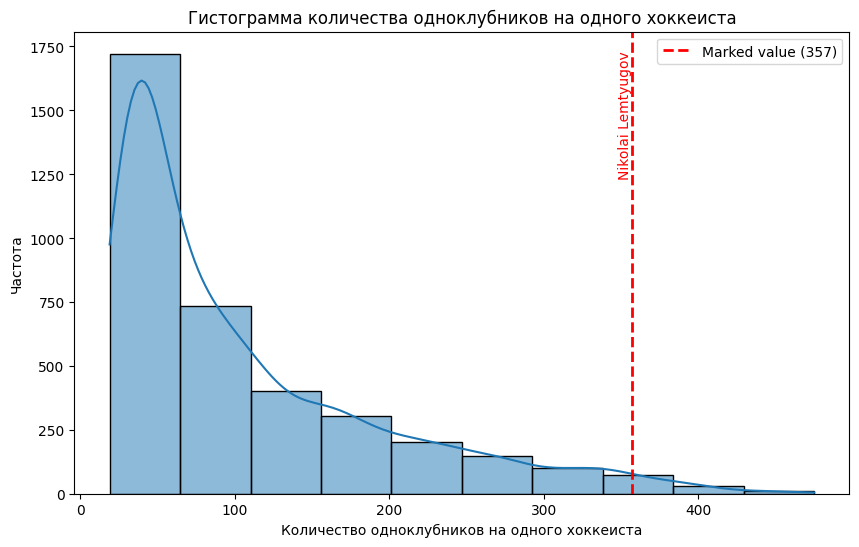

In [143]:
plt.figure(figsize=(10, 6))
sns.histplot(data=count_clubmates_data,
             x='count_clubmates_id',
             bins=10,
             kde=True)

plt.xlabel('Количество одноклубников на одного хоккеиста')
plt.ylabel('Частота')
plt.title('Гистограмма количества одноклубников на одного хоккеиста')

# Выделение значения 357 цветом
value_to_mark = 357
plt.axvline(value_to_mark, color='red', linestyle='dashed', linewidth=2, label=f'Marked value ({value_to_mark})')

# Подпись игрока "Nikolai Lemtyugov"
player_name = "Nikolai Lemtyugov"
plt.text(value_to_mark, plt.ylim()[1] * 0.96, player_name, color='red', ha='right', va='top', fontsize=10, rotation=90)

plt.legend()
plt.show()

Из гистограммы распределения видно, что у Николая Лемтюгова много одноклубников относительно других игроков, но это число не является максимальным.

## Гипотеза 2: Правда ли, что игроки с низким значением числа Лемтюгова играли в среднем в большем количестве команд, чем игроки, у которых это значение больше?

Здесь нам нужны данные о количество команд, обратимся к датафрейму clubmates_dataframe:

In [144]:
clubmates_dataframe.head()

player_player player_id_player     team start_date_player  \
3   Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
11  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
12  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
14  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
15  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   

   end_date_player player_clubmate player_id_clubmate start_date_clubmate  \
3       2016-03-02  Semir Ben-Amor              22344          2014-09-04   
11      2016-03-02  Ryan Gunderson              22345          2014-09-04   
12      2016-03-02     Frank Gymer              22372          2015-11-29   
14      2016-03-02   Niklas Hagman              19382          2014-09-04   
15      2016-03-02       Riku Hahl              22353          2014-09-04   

   end_date_clubmate  
3         2015-03-13  
11        2015-03-19  
12        2017-02-27  
14        2016-03-02  
15        2015-03-19

Сгруппируем данные по игроку и получим количество команд:

In [145]:
clubmates_teams = clubmates_dataframe.groupby('player_id_player')['team'].nunique().reset_index().sort_values(by='team')
clubmates_teams

player_id_player  team
1859            20929     1
1511            18951     1
2668            27504     1
2670            27540     1
1507            18946     1
...               ...   ...
108             13679    10
280             14551    10
3605              548    11
52              12990    11
221             14299    11

[3720 rows x 2 columns]

Количество команд для всех 3720 игроков - от 0 до 11.

In [146]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/clubmates_teams.csv'

# Сохранение датафрейма в CSV-файле
#clubmates_teams.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

Посмотрим количество команд у Лемтюгова:

In [147]:
clubmates_teams[clubmates_teams['player_id_player']=='13705']

player_id_player  team
116            13705    10

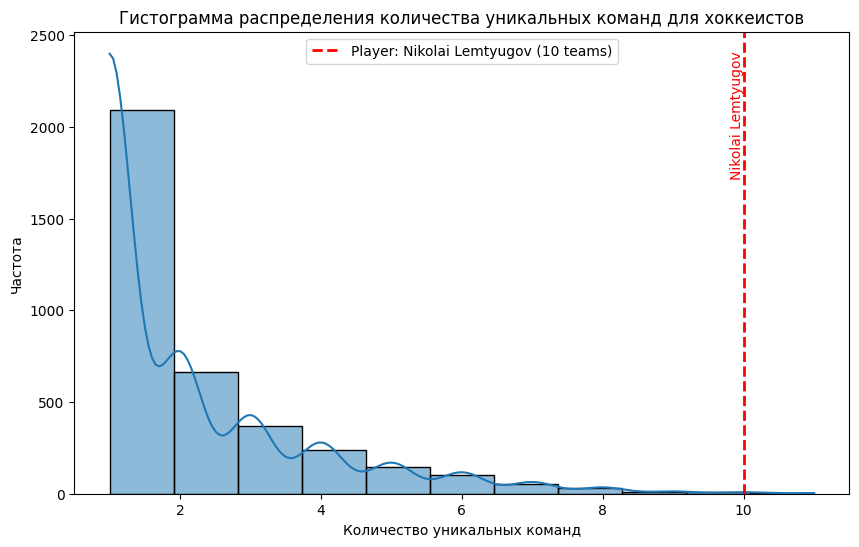

In [148]:
plt.figure(figsize=(10, 6))
sns.histplot(data=
             clubmates_teams, x='team',
             bins=11,
             kde=True)

# Отмечаем значение для игрока "Nikolai Lemtyugov"
player_id = '13705'
team_count = clubmates_teams.loc[clubmates_teams['player_id_player'] == player_id, 'team'].values[0]
plt.axvline(team_count, color='red', linestyle='dashed', linewidth=2, label=f'Player: Nikolai Lemtyugov ({team_count} teams)')

# Подпись игрока "Nikolai Lemtyugov" вертикально по красной оси
plt.text(team_count, plt.ylim()[1] * 0.96, 'Nikolai Lemtyugov', color='red', ha='right', va='top', fontsize=10, rotation='vertical')

plt.xlabel('Количество уникальных команд')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества уникальных команд для хоккеистов')
plt.legend()
plt.show()

Дальше работаем с датасетами clubmates_teams, lemtyugov_number.

In [149]:
# Объединение по общему столбцу 'player_id' и 'player_id_player'
merged_df = clubmates_teams.merge(lemtyugov_number,
                                  left_on='player_id_player',
                                  right_on='player_id')
merged_df.drop('player_id_player', axis=1, inplace=True)

merged_df = merged_df[['player_id', 'lemtyugov_number','team' ]]

In [150]:
merged_df

player_id  lemtyugov_number  team
0        20929                 2     1
1        18951                 2     1
2        27504                 2     1
3        27540                 3     1
4        18946                 2     1
...        ...               ...   ...
3715     13679                 1    10
3716     14551                 2    10
3717       548                 2    11
3718     12990                 2    11
3719     14299                 2    11

[3720 rows x 3 columns]

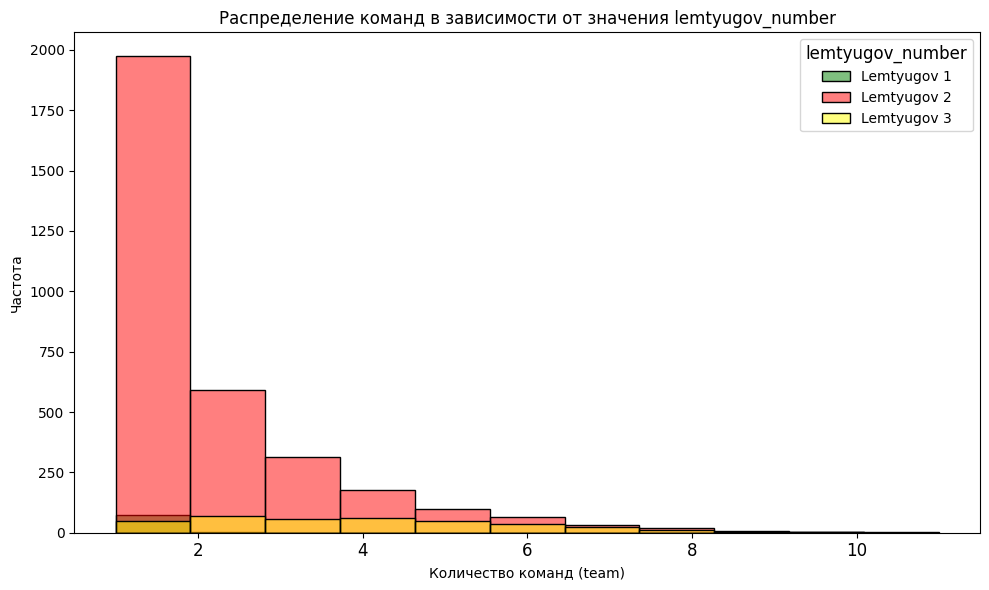

In [151]:
plt.figure(figsize=(10, 6))

custom_colors = ['blue', 'yellow', 'red', 'green']

sns.histplot(data=merged_df,
             x='team',
             hue='lemtyugov_number',
             kde=False,
             bins=11,
             palette=custom_colors)  # Использование новой палитры)

plt.xlabel('Количество команд (team)')
plt.ylabel('Частота')
plt.title('Распределение команд в зависимости от значения lemtyugov_number')

plt.legend(title='lemtyugov_number',
           title_fontsize='large',
           labels=['Lemtyugov 3', 'Lemtyugov 2', 'Lemtyugov 1'][::-1]
           )

plt.xticks(fontsize=12)
plt.tight_layout()

plt.show()

In [152]:
# Группировка по столбцу 'lemtyugov_number' и вычисление количества уникальных player_id и среднего значения по team
grouped_df = merged_df.groupby('lemtyugov_number').agg(
    player_id_count=('player_id', 'nunique'),  # Количество уникальных player_id
    average_team=('team', 'mean')  # Среднее значение по столбцу 'team'
).reset_index()

In [153]:
grouped_df

lemtyugov_number  player_id_count  average_team
0                 0                1         10.00
1                 1              357          3.82
2                 2             3287          1.89
3                 3               75          1.03

Видим, что чем ниже число Лемтюгова, тем больше количество команд, в которых играл хотккеист. Проверим это утверждение с помощью статистических методов.

In [154]:
correlation = merged_df['team'].corr(merged_df['lemtyugov_number'])
correlation

-0.3535257537835313

Коэффициент корреляции -0.3535 указывает на отрицательную слабую корреляцию между количеством команд ('team') и числом Лемтюгова ('lemtyugov_number'). Отрицательное значение коэффициента говорит о том, что при увеличении значения 'team', значение 'lemtyugov_number' склонно к уменьшению, и наоборот.

Такая корреляция не является сильной и не позволяет сделать однозначный вывод о прямой зависимости между этими двумя переменными. Однако она может указывать на то, что в целом у хоккеистов с более высоким значением количества команд (team), то есть игравших в большем количестве команд, есть склонность к меньшему числу Лемтюгова, то есть более сильной близости к легендарному хоккеисту.

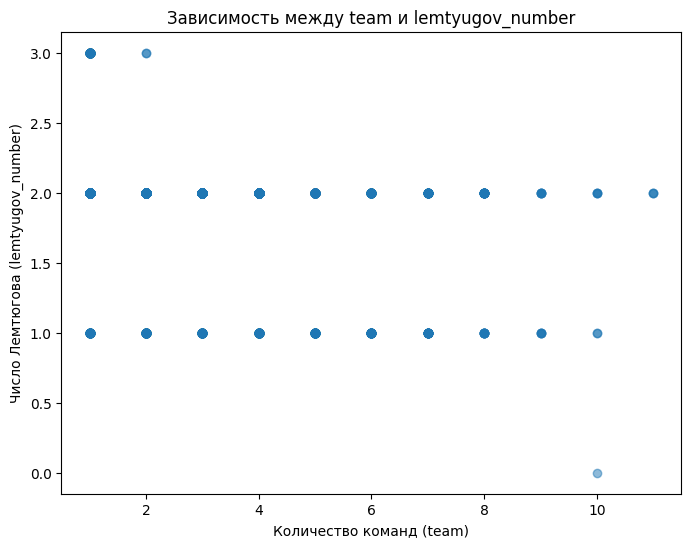

In [155]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['team'], merged_df['lemtyugov_number'], alpha=0.5)
plt.xlabel('Количество команд (team)')
plt.ylabel('Число Лемтюгова (lemtyugov_number)')
plt.title('Зависимость между team и lemtyugov_number')
plt.show()

На графике рассеяния видно точки, представляющие каждую запись датафрейма. Точки расположены преимущественно вокруг линии или формируют какую-либо общую форму (прямую линию), это может указывать на наличие связи между количеством команд и числом Лемтюгова.

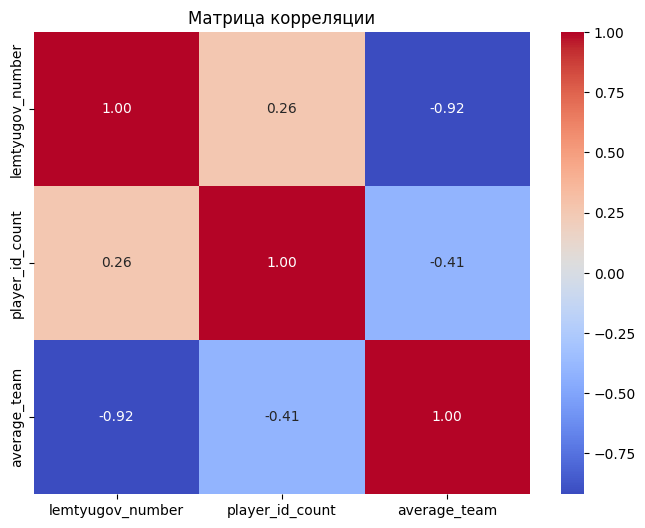

In [156]:
correlation_matrix = grouped_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

Разделим данные на три выборки по значениям числа Лемтюгова 1, 2, 3. Число 0 - только у самого Лемтюгова (и в выборке будет только один человек, что недостаточно), поэтому число 0 не будем рассматривать.

In [157]:
sample_1 = merged_df[merged_df['lemtyugov_number'] == 1]['team']
sample_2 = merged_df[merged_df['lemtyugov_number'] == 2]['team']
sample_3 = merged_df[merged_df['lemtyugov_number'] == 3]['team']

Для работы с несколькими выборками будем использовать метод ANOVA.

In [158]:
# Проведение однофакторного дисперсионного анализа (ANOVA)
f_statistic, p_value = stats.f_oneway(sample_1, sample_2, sample_3)

print("F-статистика:", f_statistic)
print("p-значение:", p_value)

F-статистика: 273.11281629747526
p-значение: 2.1685096926300114e-111


Значение F-статистики равное 273.11 и крайне маленькое p-значение (2.17e-111) указывают на то, что существуют статистически значимые различия между средними значениями 'team' в трех выборках с числом Лемтюгова 1, 2 и 3.

Таким образом, гипотезу о равенстве средних можно считать отклоненной. Это говорит о том, что средние значения количества команд ('average_team') значимо различаются в зависимости от числа Лемтюгова.

Для более полного анализа, также важно проверить предположения, лежащие в основе ANOVA, включая нормальность распределения данных и равенство дисперсий. Также можно провести дополнительные пост-хок анализы, чтобы выявить, между какими именно группами наблюдаются статистически значимые различия.


In [159]:
# Проверка равенства дисперсий
statistic, p_value = stats.levene(sample_1, sample_2, sample_3)

print("Тест Левена:")
print("Статистика:", statistic)
print("p-значение:", p_value)

Тест Левена:
Статистика: 63.77807295446909
p-значение: 5.838751648517939e-28


Значение статистики теста Левена равное 63.78 и очень маленькое p-значение (5.84e-28) указывают на то, что дисперсии между выборками с числом Лемтюгова 1, 2 и 3 статистически значимо отличаются. Таким образом, гипотезу о равенстве дисперсий можно отклонить.

Учитывая результаты теста Левена, для проведения однофакторного дисперсионного анализа (ANOVA) можно использовать методы, учитывающие неоднородность дисперсий, например, Welch's ANOVA.

In [160]:
# Проведение Welch's ANOVA с использованием pingouin
anova_result = pg.welch_anova(data=merged_df, dv='team', between='lemtyugov_number')
anova_result

Source  ddof1    ddof2      F  p-unc  np2
0  lemtyugov_number      3 1,096.05 415.61   0.00 0.13

Предоставленные результаты Welch's ANOVA показывают следующие статистики:

* Source: Источник вариации (фактор), для которого была выполнена анализ.
* ddof1: Степени свободы числителя.
* ddof2: Степени свободы знаменателя.
* F: Значение статистики F (F-статистика).
* p-unc: Двустороннее p-значение для проверки нулевой гипотезы о равенстве средних.
* np2: Коэффициент детерминации (effect size) для данного фактора.

В данном случае, анализ выполнен для фактора 'lemtyugov_number' с тремя уровнями (1, 2 и 3), и результаты указывают на следующее:

Значение статистики F (F-статистика) равно 415.61.
Двустороннее p-значение (p-unc) очень маленькое (0.00), что указывает на статистически значимые различия в средних значениях 'team' для трех уровней числа Лемтюгова.
Коэффициент детерминации (np2) равен 0.13, что означает, что фактор 'lemtyugov_number' объясняет около 13% дисперсии в значениях 'team'.
Таким образом, результаты подтверждают статистически значимые различия в средних значениях 'team' между группами с разными значениями числа Лемтюгова (1, 2 и 3), и числовое значение коэффициента детерминации (effect size) показывает средний размер эффекта данного фактора.

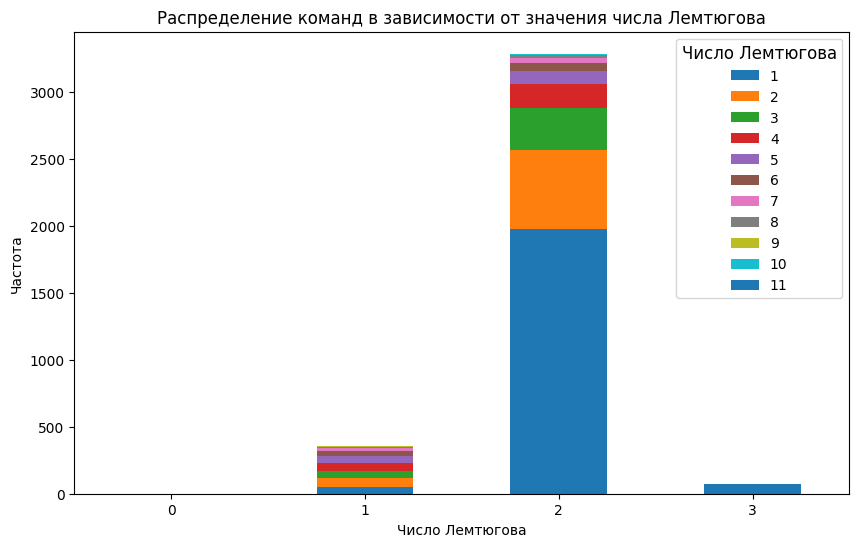

In [161]:
merged_df.groupby('lemtyugov_number')['team'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Число Лемтюгова')
plt.ylabel('Частота')
plt.title('Распределение команд в зависимости от значения числа Лемтюгова')
plt.legend(title='Число Лемтюгова', title_fontsize='large')
plt.xticks(rotation=360, fontsize=10)
#plt.tight_layout()
plt.show()

In [162]:
merged_df[merged_df['lemtyugov_number'] != 0]

player_id  lemtyugov_number  team
0        20929                 2     1
1        18951                 2     1
2        27504                 2     1
3        27540                 3     1
4        18946                 2     1
...        ...               ...   ...
3715     13679                 1    10
3716     14551                 2    10
3717       548                 2    11
3718     12990                 2    11
3719     14299                 2    11

[3719 rows x 3 columns]

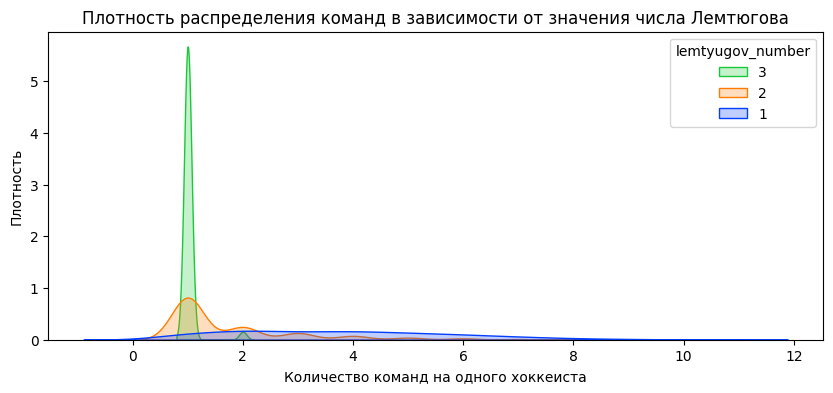

In [163]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=merged_df[merged_df['lemtyugov_number'] != 0],
            x='team',
            hue='lemtyugov_number',
            fill=True,
            common_norm=False,
            palette='bright'
            )
plt.xlabel('Количество команд на одного хоккеиста')
plt.ylabel('Плотность')
plt.title('Плотность распределения команд в зависимости от значения числа Лемтюгова')
plt.legend(title='lemtyugov_number', loc='upper right', labels=['3', '2', '1'])
plt.show()

Визуально график плотности распределения выглядит как гладкая кривая, которая описывает, какие значения вероятности более вероятны или менее вероятны в данном наборе данных.

## Гипотеза 3: Есть ли игроки, у которых отсутствует число Лемтюгова (нет связей через других игроков)?

Число Лемтюгова было рассчитано на основе датафрейма clubmates_dataframe с 3720 уникальными игроками.

In [164]:
clubmates_dataframe.head()

player_player player_id_player     team start_date_player  \
3   Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
11  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
12  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
14  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
15  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   

   end_date_player player_clubmate player_id_clubmate start_date_clubmate  \
3       2016-03-02  Semir Ben-Amor              22344          2014-09-04   
11      2016-03-02  Ryan Gunderson              22345          2014-09-04   
12      2016-03-02     Frank Gymer              22372          2015-11-29   
14      2016-03-02   Niklas Hagman              19382          2014-09-04   
15      2016-03-02       Riku Hahl              22353          2014-09-04   

   end_date_clubmate  
3         2015-03-13  
11        2015-03-19  
12        2017-02-27  
14        2016-03-02  
15        2015-03-19

In [165]:
clubmates_dataframe['player_id_player'].nunique()

3720

Значения числа Лемтюгова были записаны в датафрейм lemtyugov_number. Группировка показывает, что значения 0, 1, 2, 3 соотвествуют тому или иному количеству игроков, пропущенных данных нет.

In [166]:
lemtyugov_number

player_id  lemtyugov_number
0        13705                 0
1        10541                 1
2        10769                 1
3        10992                 1
4        11014                 1
...        ...               ...
3715     16546                 3
3716     18956                 3
3717     16547                 3
3718     19125                 3
3719     40832                 3

[3720 rows x 2 columns]

In [167]:
lemtyugov_number.describe()

lemtyugov_number
count          3,720.00
mean               1.92
std                0.33
min                0.00
25%                2.00
50%                2.00
75%                2.00
max                3.00

In [168]:
lemtyugov_number.groupby('lemtyugov_number')['player_id'].count().reset_index()

lemtyugov_number  player_id
0                 0          1
1                 1        357
2                 2       3287
3                 3         75

In [169]:
lemtyugov_number['player_id'].nunique()

3720

In [170]:
lemtyugov_number.isnull().sum()

player_id           0
lemtyugov_number    0
dtype: int64

У всех 3720 игроков есть число Лемтюгова (от 0 до 3), нет таких игроков в КХЛ, которые бы никак не были связаны с Николаем Лемтюговым.

## Медианное значение числа Лемтюгова. Изменение этого значения от сезона к сезону

### Медианное значение числа Лемтюгова

Рассчитаем медианное значение числа Лемтюгова.

In [171]:
lemtyugov_number['lemtyugov_number'].median()

2.0

In [172]:
merged_df['lemtyugov_number'].median()

2.0

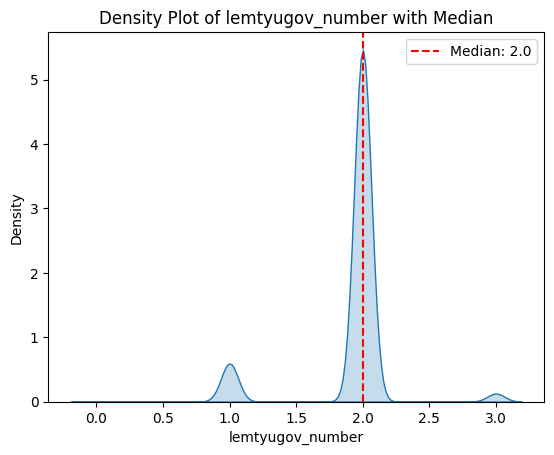

In [173]:
median_value = merged_df['lemtyugov_number'].median()
sns.kdeplot(data=merged_df['lemtyugov_number'], shade=True)
# добавим отметку медианы на графике
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median: {median_value}')
plt.xlabel('lemtyugov_number')
plt.ylabel('Density')
plt.title('Density Plot of lemtyugov_number with Median')
plt.legend()
plt.show()

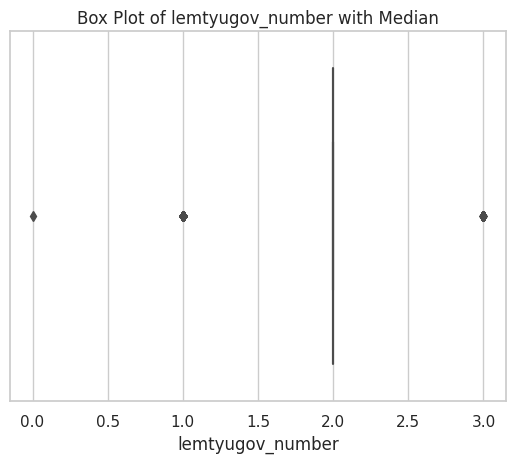

In [174]:
sns.set(style="whitegrid")
sns.boxplot(data=merged_df, x='lemtyugov_number')
plt.xlabel('lemtyugov_number')
plt.title('Box Plot of lemtyugov_number with Median')
plt.show()

Медианное значение - 2.

### Изменение этого значения от сезона к сезону

Далее рассмотрим изменение числа от сезона к сезону:

In [175]:
players.head()

player player_id          team start_date   end_date
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09

In [176]:
players['start_year'] = players['start_date'].dt.year
players['end_year'] = players['end_date'].dt.year

In [177]:
#players.head()

In [178]:
season_start_date_mapping = {
    '2008': '02-09-08',
    '2009': '10-09-09',
    '2010': '09-09-10',
    '2011': '07-09-11',
    '2012': '04-09-12',
    '2013': '04-09-13',
    '2014': '03-09-14',
    '2015': '24-08-15',
    '2016': '22-08-16',
    '2017': '21-08-17',
    '2018': '01-09-18',
    '2019': '01-09-19',
    '2020': '02-09-20',
    '2021': '01-09-21',
    '2022': '01-09-22',
    '2023': '01-09-23'
}

In [179]:
season_end_date_mapping = {
    '2009': '12-04-09',
    '2010': '27-04-10',
    '2011': '16-04-11',
    '2012': '25-04-12',
    '2013': '17-04-13',
    '2014': '30-04-14',
    '2015': '19-04-15',
    '2016': '19-04-16',
    '2017': '16-04-17',
    '2018': '01-03-18',
    '2019': '22-02-19',
    '2020': '27-02-20',
    '2021': '28-04-21',
    '2022': '30-04-22',
    '2023': '29-04-23',
    '2023': '29-04-23'
}

In [180]:
# Создание функций для получения дат начала и конца сезона по году из словарей
def get_season_start(year):
    return pd.to_datetime(season_start_date_mapping[str(year)], format='%d-%m-%y')

def get_season_end(year):
    return pd.to_datetime(season_end_date_mapping[str(year)], format='%d-%m-%y')

In [181]:
players['season_start'] = players['start_year'].apply(get_season_start)

In [182]:
players_2014 = players[players['start_year']==2014]
players_2014

player player_id          team start_date   end_date  \
0      Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
18          Rodrigo Abols     20861      Dinamo R 2014-12-27 2015-02-24   
52             Ari Ahonen     18767       Admiral 2014-09-04 2014-09-27   
64        Rafael Akhmetov     14914          Amur 2014-12-24 2015-09-20   
65        Rafael Akhmetov     14914      HC Sochi 2014-09-08 2014-12-14   
...                   ...       ...           ...        ...        ...   
8106         Airat Ziazov     16217          Ugra 2014-11-06 2014-11-29   
8116  Stanislav Zinchenko     18981         Barys 2014-10-12 2014-10-27   
8136         Vitaly Zotov     15937  Metallurg Nk 2014-09-04 2014-12-10   
8154           Ilya Zubov      7211       Admiral 2014-01-13 2015-02-24   
8176      Maxim Zyuzyakin     15734          Lada 2014-09-08 2014-09-27   

      start_year  end_year season_start  
0           2014      2016   2014-09-03  
18          2014      2015   2014-09-03  
52          2014      2014   2014-09-03  
64          2014      2015   2014-09-03  
65          2014      2014   2014-09-03  
...          ...       ...          ...  
8106        2014      2014   2014-09-03  
8116        2014      2014   2014-09-03  
8136        2014      2014   2014-09-03  
8154        2014      2015   2014-09-03  
8176        2014      2014   2014-09-03  

[631 rows x 8 columns]

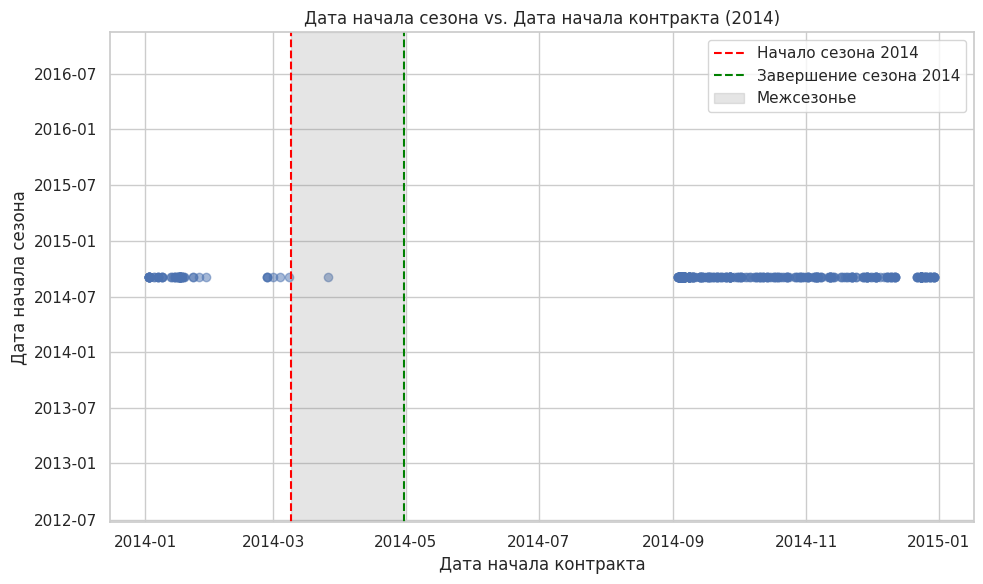

In [183]:
# Построение точечной диаграммы
plt.figure(figsize=(10, 6))

plt.scatter(players_2014['start_date'],  # здесь ось X
            players_2014['season_start'],  # здесь ось Y
            color='b',
            alpha=0.5)
plt.xlabel('Дата начала контракта')
plt.ylabel('Дата начала сезона')
plt.title('Дата начала сезона vs. Дата начала контракта (2014)')
plt.grid(True)

# Добавление красной и зеленой вертикальных линий для начала и завершения сезона 2014
plt.axvline(pd.to_datetime('03-09-14'), color='red', linestyle='--', label='Начало сезона 2014')
plt.axvline(pd.to_datetime('30-04-14'), color='green', linestyle='--', label='Завершение сезона 2014')

# Добавление заштрихованной области для межсезонья
plt.axvspan(pd.to_datetime('03-09-14'), pd.to_datetime('30-04-14'), alpha=0.2, color='gray', label='Межсезонье')

plt.legend()
plt.tight_layout()
plt.show()

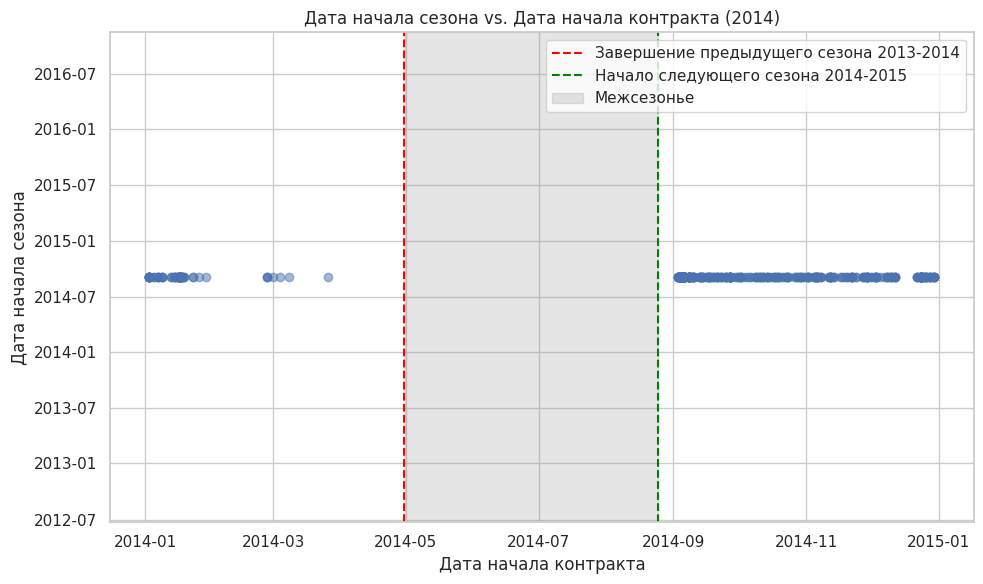

In [184]:
plt.figure(figsize=(10, 6))

plt.scatter(players_2014['start_date'],  # здесь ось X
            players_2014['season_start'],  # здесь ось Y
            color='b',
            alpha=0.5)
plt.xlabel('Дата начала контракта')
plt.ylabel('Дата начала сезона')
plt.title('Дата начала сезона vs. Дата начала контракта (2014)')
plt.grid(True)

# Добавление красной и зеленой вертикальных линий для начала и завершения сезонов
plt.axvline(pd.to_datetime('2014, 4, 30'), color='red', linestyle='--', label='Завершение предыдущего сезона 2013-2014')
plt.axvline(pd.to_datetime('2014, 8, 25'), color='green', linestyle='--', label='Начало следующего сезона 2014-2015')

# Добавление заштрихованной области для межсезонья
plt.axvspan(pd.to_datetime('2014, 4, 30'), pd.to_datetime('2014, 8, 25'), alpha=0.2, color='gray', label='Межсезонье')

plt.legend()
plt.tight_layout()
plt.show()

In [185]:
season_dates_khl = {
    '2008-2009': (datetime(2008, 9, 2), datetime(2009, 4, 12)),
    '2009-2010': (datetime(2009, 9, 10), datetime(2010, 4, 22)),
    '2010-2011': (datetime(2010, 9, 8), datetime(2011, 4, 20)),
    '2011-2012': (datetime(2011, 9, 7), datetime(2012, 4, 29)),
    '2012-2013': (datetime(2012, 9, 4), datetime(2013, 6, 24)),
    '2013-2014': (datetime(2013, 9, 4), datetime(2014, 4, 30)),
    '2014-2015': (datetime(2014, 8, 25), datetime(2015, 4, 30)),
    '2015-2016': (datetime(2015, 8, 24), datetime(2016, 4, 19)),
    '2016-2017': (datetime(2016, 8, 22), datetime(2017, 4, 16)),
    '2017-2018': (datetime(2017, 8, 21), datetime(2018, 4, 19)),
    '2018-2019': (datetime(2018, 9, 1), datetime(2019, 4, 19)),
    '2019-2020': (datetime(2019, 9, 1), datetime(2020, 3, 12)),
    '2020-2021': (datetime(2020, 9, 2), datetime(2021, 5, 7)),
    '2021-2022': (datetime(2021, 9, 1), datetime(2022, 4, 30)),
    '2022-2023': (datetime(2022, 9, 1), datetime(2023, 4, 29))
    }

In [186]:
players.head()

player player_id          team start_date   end_date  \
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22   
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11   
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27   
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09   

   start_year  end_year season_start  
0        2014      2016   2014-09-03  
1        2010      2012   2010-09-09  
2        2021      2022   2021-09-01  
3        2019      2021   2019-09-01  
4        2016      2019   2016-08-22

In [187]:
# Функция для определения сезона на основе даты
def get_season(date):
    for season, (start_date, end_date) in season_dates_khl.items():
        if start_date <= date <= end_date:
            return season
    return None

In [188]:
# Применяем функцию к столбцу 'start_date' и создаем новый столбец 'season_on'
players['season_on'] = players['start_date'].apply(get_season)

In [189]:
# Применяем функцию к столбцу 'start_date' и создаем новый столбец 'season_on'
players['season_off'] = players['end_date'].apply(get_season)

In [190]:
players

player player_id            team start_date   end_date  \
0     Juhamatti Aaltonen     16785         Jokerit 2014-09-04 2016-03-02   
1     Juhamatti Aaltonen     16785    Metallurg Mg 2010-09-09 2012-03-22   
2          Miro Aaltonen     17585          Vityaz 2021-09-02 2022-01-11   
3          Miro Aaltonen     17585             SKA 2019-12-17 2021-02-27   
4          Miro Aaltonen     17585          Vityaz 2016-08-27 2019-12-09   
...                  ...       ...             ...        ...        ...   
8174       Dmitry Zyuzin     13961    Metallurg Nk 2010-10-14 2011-02-16   
8175       Dmitry Zyuzin     13961  Salavat Yulaev 2008-10-27 2008-10-27   
8176     Maxim Zyuzyakin     15734            Lada 2014-09-08 2014-09-27   
8177     Maxim Zyuzyakin     15734    Metallurg Nk 2013-09-05 2013-10-03   
8178     Maxim Zyuzyakin     15734       Lokomotiv 2010-03-05 2011-01-04   

      start_year  end_year season_start  season_on season_off  
0           2014      2016   2014-09-03  2014-2015  2015-2016  
1           2010      2012   2010-09-09  2010-2011  2011-2012  
2           2021      2022   2021-09-01  2021-2022  2021-2022  
3           2019      2021   2019-09-01  2019-2020  2020-2021  
4           2016      2019   2016-08-22  2016-2017  2019-2020  
...          ...       ...          ...        ...        ...  
8174        2010      2011   2010-09-09  2010-2011  2010-2011  
8175        2008      2008   2008-09-02  2008-2009  2008-2009  
8176        2014      2014   2014-09-03  2014-2015  2014-2015  
8177        2013      2013   2013-09-04  2013-2014  2013-2014  
8178        2010      2011   2010-09-09  2009-2010  2010-2011  

[8179 rows x 10 columns]

In [191]:
players.isnull().sum()

player           0
player_id        0
team             0
start_date       0
end_date         0
start_year       0
end_year         0
season_start     0
season_on        0
season_off      36
dtype: int64

In [192]:
players[players['season_off'].isnull()]

player player_id     team start_date   end_date  \
357        Yury I. Babenko     10892   HC MVD 2009-09-12 2010-04-27   
374        Alexei Badyukov      4087  Ak Bars 2008-12-23 2010-04-27   
758       Alexander Boikov     10855   HC MVD 2009-09-18 2010-04-27   
1300         Roman Derlyuk     13786   HC MVD 2008-09-02 2010-04-27   
1320       Yury Dobryshkin      4699   HC MVD 2009-10-05 2010-04-27   
1448          Matt Ellison     15217   HC MVD 2009-09-12 2010-04-27   
1639       Evgeny Fyodorov      4014   HC MVD 2009-09-12 2010-04-27   
1735       Michael Garnett     14900   HC MVD 2008-09-02 2010-04-27   
1915     Vladimir Gorbunov      3538   HC MVD 2008-09-02 2010-04-27   
2267        Hannes Hyvonen     15545  Ak Bars 2010-01-18 2010-04-27   
2947         Denis Kokarev      3507   HC MVD 2008-09-02 2010-04-27   
3457       Roman Kukumberg     13683  Ak Bars 2010-02-01 2010-04-23   
3552       Andrei Kuzmenko     19215     CSKA 2014-09-14 2018-04-22   
4560        Denis Mosalyov     14444   HC MVD 2008-09-05 2010-04-27   
4585     Andrei Mukhachyov      3552  Ak Bars 2009-01-08 2010-04-27   
4845           Filip Novak     15248   HC MVD 2009-09-12 2010-04-27   
4925          Atte Ohtamaa     21802  Ak Bars 2016-08-23 2018-04-22   
5215      Andrei Pervyshin       279  Ak Bars 2008-09-03 2010-04-27   
5262         Kirill Petrov     14622     CSKA 2016-01-04 2018-04-22   
5363           Geoff Platt     15373     CSKA 2015-08-24 2018-04-20   
5499   Nikita A. Popugayev     22684     CSKA 2017-11-22 2018-04-22   
6134    Artyom M. Sergeyev     16675     CSKA 2015-11-10 2018-04-22   
6309    Alexander Shibayev     14321   HC MVD 2008-09-13 2010-04-27   
6436       Mikhail Sidorov     21011  Ak Bars 2015-12-23 2018-04-22   
6785     Gennady Stolyarov       548   HC MVD 2010-03-07 2010-04-27   
6797         Martin Strbak      5454   HC MVD 2009-09-12 2010-04-27   
7091       Vasily Tokranov     14732  Ak Bars 2009-03-27 2018-04-22   
7125       Pavel Trakhanov      4367   HC MVD 2008-09-02 2010-04-27   
7187       Alexei Tsvetkov      6336   HC MVD 2008-09-02 2010-04-27   
7240         Alexei Ugarov     14285   HC MVD 2008-09-02 2010-04-27   
7392         Maxim Velikov      4336   HC MVD 2008-09-02 2010-04-27   
7502     Alexei Vl. Volkov      6488   HC MVD 2009-09-12 2010-04-27   
7522  Konstantin N. Volkov      3404   HC MVD 2009-09-12 2010-04-27   
7905        Mikhail Yunkov       595  Ak Bars 2009-09-12 2010-04-27   
7942      Ruslan Zainullin      4703   HC MVD 2008-09-07 2010-04-23   
8038      Vladimir Zharkov     14527     CSKA 2012-09-05 2018-04-22   

      start_year  end_year season_start  season_on season_off  
357         2009      2010   2009-09-10  2009-2010       None  
374         2008      2010   2008-09-02  2008-2009       None  
758         2009      2010   2009-09-10  2009-2010       None  
1300        2008      2010   2008-09-02  2008-2009       None  
1320        2009      2010   2009-09-10  2009-2010       None  
1448        2009      2010   2009-09-10  2009-2010       None  
1639        2009      2010   2009-09-10  2009-2010       None  
1735        2008      2010   2008-09-02  2008-2009       None  
1915        2008      2010   2008-09-02  2008-2009       None  
2267        2010      2010   2010-09-09  2009-2010       None  
2947        2008      2010   2008-09-02  2008-2009       None  
3457        2010      2010   2010-09-09  2009-2010       None  
3552        2014      2018   2014-09-03  2014-2015       None  
4560        2008      2010   2008-09-02  2008-2009       None  
4585        2009      2010   2009-09-10  2008-2009       None  
4845        2009      2010   2009-09-10  2009-2010       None  
4925        2016      2018   2016-08-22  2016-2017       None  
5215        2008      2010   2008-09-02  2008-2009       None  
5262        2016      2018   2016-08-22  2015-2016       None  
5363        2015      2018   2015-08-24  2015-2016       None  
5499        2017      2018   2017-08-21  2017-20

In [193]:
season_dataframe = pd.DataFrame.from_dict(season_dates_khl, orient='index', columns=['Start_Date', 'End_Date'])
season_dataframe.index.name = 'Season'

In [194]:
season_dataframe

Start_Date   End_Date
Season                         
2008-2009 2008-09-02 2009-04-12
2009-2010 2009-09-10 2010-04-22
2010-2011 2010-09-08 2011-04-20
2011-2012 2011-09-07 2012-04-29
2012-2013 2012-09-04 2013-06-24
2013-2014 2013-09-04 2014-04-30
2014-2015 2014-08-25 2015-04-30
2015-2016 2015-08-24 2016-04-19
2016-2017 2016-08-22 2017-04-16
2017-2018 2017-08-21 2018-04-19
2018-2019 2018-09-01 2019-04-19
2019-2020 2019-09-01 2020-03-12
2020-2021 2020-09-02 2021-05-07
2021-2022 2021-09-01 2022-04-30
2022-2023 2022-09-01 2023-04-29

In [195]:
fig = px.timeline(season_dataframe,
                  x_start="Start_Date",
                  x_end="End_Date",
                  y=season_dataframe.index,
                  color=season_dataframe.index,
                 title = 'Сезоны КХЛ')
#fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [196]:
season_dataframe

Start_Date   End_Date
Season                         
2008-2009 2008-09-02 2009-04-12
2009-2010 2009-09-10 2010-04-22
2010-2011 2010-09-08 2011-04-20
2011-2012 2011-09-07 2012-04-29
2012-2013 2012-09-04 2013-06-24
2013-2014 2013-09-04 2014-04-30
2014-2015 2014-08-25 2015-04-30
2015-2016 2015-08-24 2016-04-19
2016-2017 2016-08-22 2017-04-16
2017-2018 2017-08-21 2018-04-19
2018-2019 2018-09-01 2019-04-19
2019-2020 2019-09-01 2020-03-12
2020-2021 2020-09-02 2021-05-07
2021-2022 2021-09-01 2022-04-30
2022-2023 2022-09-01 2023-04-29

In [197]:
players.head()

player player_id          team start_date   end_date  \
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22   
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11   
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27   
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09   

   start_year  end_year season_start  season_on season_off  
0        2014      2016   2014-09-03  2014-2015  2015-2016  
1        2010      2012   2010-09-09  2010-2011  2011-2012  
2        2021      2022   2021-09-01  2021-2022  2021-2022  
3        2019      2021   2019-09-01  2019-2020  2020-2021  
4        2016      2019   2016-08-22  2016-2017  2019-2020

In [198]:
players_2008 = players[
    players['start_date']  # дата прихода игрока в команду
        < datetime(2009, 4, 12) # дата завершения сезона
        ]
players_2008

player player_id            team start_date   end_date  \
5     Ruslan Abdrakhmanov     13041            Amur 2008-09-02 2009-02-14   
14         Denis Abdullin     13873          HC MVD 2008-09-02 2009-11-23   
37     Dmitry Afanasenkov     13490        Dynamo M 2008-09-03 2009-09-24   
49            Ivan Ageyev     15376            CSKA 2008-09-22 2008-09-22   
56          Johan Akerman     15218       Lokomotiv 2008-09-02 2009-04-12   
...                   ...       ...             ...        ...        ...   
8146       Sergei Zuborev      5336          Vityaz 2008-09-02 2010-10-29   
8161         Andrei Zuyev      6335         Traktor 2008-12-26 2008-12-26   
8163       Sergei Zvyagin      2820       Lokomotiv 2008-09-02 2009-04-12   
8173        Andrei Zyuzin     13702             SKA 2008-09-03 2010-10-18   
8175        Dmitry Zyuzin     13961  Salavat Yulaev 2008-10-27 2008-10-27   

      start_year  end_year season_start  season_on season_off  
5           2008      2009   2008-09-02  2008-2009  2008-2009  
14          2008      2009   2008-09-02  2008-2009  2009-2010  
37          2008      2009   2008-09-02  2008-2009  2009-2010  
49          2008      2008   2008-09-02  2008-2009  2008-2009  
56          2008      2009   2008-09-02  2008-2009  2008-2009  
...          ...       ...          ...        ...        ...  
8146        2008      2010   2008-09-02  2008-2009  2010-2011  
8161        2008      2008   2008-09-02  2008-2009  2008-2009  
8163        2008      2009   2008-09-02  2008-2009  2008-2009  
8173        2008      2010   2008-09-02  2008-2009  2010-2011  
8175        2008      2008   2008-09-02  2008-2009  2008-2009  

[872 rows x 10 columns]

In [199]:
season_dates_khl

{'2008-2009': (datetime.datetime(2008, 9, 2, 0, 0),
  datetime.datetime(2009, 4, 12, 0, 0)),
 '2009-2010': (datetime.datetime(2009, 9, 10, 0, 0),
  datetime.datetime(2010, 4, 22, 0, 0)),
 '2010-2011': (datetime.datetime(2010, 9, 8, 0, 0),
  datetime.datetime(2011, 4, 20, 0, 0)),
 '2011-2012': (datetime.datetime(2011, 9, 7, 0, 0),
  datetime.datetime(2012, 4, 29, 0, 0)),
 '2012-2013': (datetime.datetime(2012, 9, 4, 0, 0),
  datetime.datetime(2013, 6, 24, 0, 0)),
 '2013-2014': (datetime.datetime(2013, 9, 4, 0, 0),
  datetime.datetime(2014, 4, 30, 0, 0)),
 '2014-2015': (datetime.datetime(2014, 8, 25, 0, 0),
  datetime.datetime(2015, 4, 30, 0, 0)),
 '2015-2016': (datetime.datetime(2015, 8, 24, 0, 0),
  datetime.datetime(2016, 4, 19, 0, 0)),
 '2016-2017': (datetime.datetime(2016, 8, 22, 0, 0),
  datetime.datetime(2017, 4, 16, 0, 0)),
 '2017-2018': (datetime.datetime(2017, 8, 21, 0, 0),
  datetime.datetime(2018, 4, 19, 0, 0)),
 '2018-2019': (datetime.datetime(2018, 9, 1, 0, 0),
  datetime.da

In [200]:
season_dates_khl['2008-2009']

(datetime.datetime(2008, 9, 2, 0, 0), datetime.datetime(2009, 4, 12, 0, 0))

In [201]:
season_dates_khl['2008-2009'][-1]

datetime.datetime(2009, 4, 12, 0, 0)

In [202]:
for key, date_list in season_dates_khl.items():
    last_date = date_list[-1]  # Получаем последнюю дату в списке

    print(f"Key: {key}, Last Date: {last_date}")

Key: 2008-2009, Last Date: 2009-04-12 00:00:00
Key: 2009-2010, Last Date: 2010-04-22 00:00:00
Key: 2010-2011, Last Date: 2011-04-20 00:00:00
Key: 2011-2012, Last Date: 2012-04-29 00:00:00
Key: 2012-2013, Last Date: 2013-06-24 00:00:00
Key: 2013-2014, Last Date: 2014-04-30 00:00:00
Key: 2014-2015, Last Date: 2015-04-30 00:00:00
Key: 2015-2016, Last Date: 2016-04-19 00:00:00
Key: 2016-2017, Last Date: 2017-04-16 00:00:00
Key: 2017-2018, Last Date: 2018-04-19 00:00:00
Key: 2018-2019, Last Date: 2019-04-19 00:00:00
Key: 2019-2020, Last Date: 2020-03-12 00:00:00
Key: 2020-2021, Last Date: 2021-05-07 00:00:00
Key: 2021-2022, Last Date: 2022-04-30 00:00:00
Key: 2022-2023, Last Date: 2023-04-29 00:00:00


In [203]:
players.head()

player player_id          team start_date   end_date  \
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22   
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11   
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27   
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09   

   start_year  end_year season_start  season_on season_off  
0        2014      2016   2014-09-03  2014-2015  2015-2016  
1        2010      2012   2010-09-09  2010-2011  2011-2012  
2        2021      2022   2021-09-01  2021-2022  2021-2022  
3        2019      2021   2019-09-01  2019-2020  2020-2021  
4        2016      2019   2016-08-22  2016-2017  2019-2020

In [204]:
players_short = players[['player_id', 'team', 'start_date', 'end_date']]
players_short.head()

player_id          team start_date   end_date
0     16785       Jokerit 2014-09-04 2016-03-02
1     16785  Metallurg Mg 2010-09-09 2012-03-22
2     17585        Vityaz 2021-09-02 2022-01-11
3     17585           SKA 2019-12-17 2021-02-27
4     17585        Vityaz 2016-08-27 2019-12-09

#### Число Лемтюгова по сезонам

In [205]:
# Создаем пустой словарь для хранения датафреймов с игроками по сезонам
season_dataframes = {}

# Итерируемся по ключам (названиям сезонов) в словаре сезонов
for season, (start_date, end_date) in season_dates_khl.items():

    # Обрезаем полный датафрейм с игроками, чтобы данные были только за нужный период времени (сезон)

    season_df = players_short[players['start_date'] < end_date] # игрок пришел раньше, чем заончился сезон

    # Сохраняем обрезанный DataFrame в словаре под ключом сезона
    season_dataframes[season] = season_df

In [206]:
season_dataframes['2014-2015']

player_id            team start_date   end_date
0        16785         Jokerit 2014-09-04 2016-03-02
1        16785    Metallurg Mg 2010-09-09 2012-03-22
5        13041            Amur 2008-09-02 2009-02-14
9        13873         Traktor 2013-10-16 2014-09-23
10       13873         Ak Bars 2012-09-10 2013-09-19
...        ...             ...        ...        ...
8174     13961    Metallurg Nk 2010-10-14 2011-02-16
8175     13961  Salavat Yulaev 2008-10-27 2008-10-27
8176     15734            Lada 2014-09-08 2014-09-27
8177     15734    Metallurg Nk 2013-09-05 2013-10-03
8178     15734       Lokomotiv 2010-03-05 2011-01-04

[4015 rows x 4 columns]

In [207]:
# Выводим количество строк в обрезанных датафреймах для каждого сезона
for season, season_df in season_dataframes.items():
    num_rows = len(season_df)
    print(f"Season: {season}, Number of Rows: {num_rows}")

Season: 2008-2009, Number of Rows: 872
Season: 2009-2010, Number of Rows: 1302
Season: 2010-2011, Number of Rows: 1771
Season: 2011-2012, Number of Rows: 2216
Season: 2012-2013, Number of Rows: 2798
Season: 2013-2014, Number of Rows: 3414
Season: 2014-2015, Number of Rows: 4015
Season: 2015-2016, Number of Rows: 4603
Season: 2016-2017, Number of Rows: 5176
Season: 2017-2018, Number of Rows: 5754
Season: 2018-2019, Number of Rows: 6246
Season: 2019-2020, Number of Rows: 6736
Season: 2020-2021, Number of Rows: 7256
Season: 2021-2022, Number of Rows: 7753
Season: 2022-2023, Number of Rows: 8179


Теперь нужно посчитать число Лемтюгова также как и раньше, но по датафрейму, который соотвествует сезону:

*   получаем список одноклубников, объединяя датафрейм сам с собой по команде с учетом дубликатов и временных интервалов;
*   создаем граф и находим число Лемтюгова.

In [208]:
# Создаем пустой словарь для хранения объединенных датафреймов по командам
clubmates_dataframes = {}

# Итерируемся по ключам (названиям сезонов) и датафреймам в словаре season_dataframes
for season, season_df in season_dataframes.items():

    # Объединяем датафрейм сам с собой по столбцу 'team' и обрезаем по условиям
    clubmates = season_df.merge(season_df, on='team', suffixes=('_player', '_clubmate'))
    clubmates = clubmates[
                (clubmates['player_id_player'] != clubmates['player_id_clubmate']) &
                (clubmates['start_date_player'] <= clubmates['end_date_clubmate']) &
                (clubmates['start_date_clubmate'] <= clubmates['end_date_player'])
            ]

   # тут группируем по айди игрока и создаем список одноклубников
    clubmates = clubmates.groupby('player_id_player')['player_id_clubmate'].apply(list).reset_index()
    clubmates.rename(columns={'player_id_player': 'player_id', 'player_id_clubmate': 'clubmates_id'}, inplace=True)

    clubmates_dataframes[season] = clubmates

In [209]:
clubmates_dataframes['2014-2015']

player_id  \
0            1   
1        10162   
2        10176   
3        10427   
4        10541   
...        ...   
2073      9859   
2074      9860   
2075      9862   
2076      9863   
2077        99   

                                                                                                                                                                                                 clubmates_id  
0     [13873, 13490, 9435, 13923, 15889, 16119, 19294, 17292, 3607, 16118, 22027, 3920, 13916, 13805, 3945, 14982, 14887, 15732, 15482, 21983, 3614, 17754, 21111, 4014, 15977, 17632, 6440, 19058, 3538, ...  
1     [13162, 15958, 15681, 4544, 16643, 17650, 15317, 17649, 5261, 17130, 18983, 15122, 17560, 14392, 13707, 17680, 14410, 18810, 3511, 20939, 15451, 19045, 3634, 4531, 15519, 17844, 5416, 17845, 13724...  
2     [14267, 17210, 14364, 14498, 15308, 16827, 14856, 14590, 22266, 15301, 15301, 17829, 14769, 15201, 14613, 16696, 13446, 9467, 14864, 15413, 19452, 20197, 3582, 13964, 18, 13946, 15219, 15486, 1281...  
3             [14763, 14876, 4512, 13806, 14478, 6303, 13226, 13803, 15514, 6308, 14454, 9467, 5516, 4000, 13877, 4033, 14476, 11903, 15232, 13031, 5526, 4817, 14616, 4499, 14448, 15476, 15105, 392, 13928]  
4     [13873, 16221, 13490, 4508, 14909, 4799, 14647, 3989, 41, 6432, 5701, 6428, 15979, 15165, 13332, 14918, 15308, 6303, 17168, 16514, 4111, 14590, 15238, 15192, 15251, 15732, 16184, 15307, 11972, 148...  
...                                                                                                                                                                                                       ...  
2073  [3989, 15979, 14918, 4111, 15192, 15732, 16184, 14825, 10541, 14900, 14738, 15990, 14300, 17881, 14652, 13859, 4486, 16355, 15564, 16234, 17551, 13031, 22042, 19031, 5636, 372, 14430, 16178, 17862...  
2074  [13873, 13490, 9435, 3739, 16119, 13061, 3607, 16123, 16118, 3920, 13805, 13805, 14982, 4080, 14887, 15732, 725, 3614, 13863, 4537, 5694, 17632, 6440, 5307, 3995, 6485, 16810, 7016, 15127, 14299, ...  
2075  [9435, 4508, 13032, 15256, 16985, 15663, 17182, 584, 13963, 15711, 120, 15918, 14386, 6140, 14319, 4000, 5143, 13683, 13150, 15270, 15104, 17544, 13953, 8875, 4234, 14983, 4266, 17537, 9480, 15668...  
2076  [18961, 3737, 3737, 16165, 14551, 5211, 4512, 4512, 14365, 14365, 4544, 15323, 15129, 21417, 3920, 16777, 4802, 4019, 21251, 17621, 15482, 17182, 16787, 16441, 15050, 4014, 17370, 15278, 3703, 178...  
2077  [16221, 14909, 5701, 13332, 15308, 14590, 15238, 15192, 15307, 11972, 10541, 4412, 14738, 15311, 4193, 6361, 14300, 14652, 14649, 14650, 14907, 3930, 15306, 13672, 13707, 15310, 3685, 13158, 14429...  

[2078 rows x 2 columns]

In [210]:
# Выводим количество строк в датафреймах с одноклубниками для каждого сезона
for season, season_df in clubmates_dataframes.items():
    num_rows = len(season_df)
    print(f"Season: {season}, Number of Rows: {num_rows}")

Season: 2008-2009, Number of Rows: 802
Season: 2009-2010, Number of Rows: 1029
Season: 2010-2011, Number of Rows: 1202
Season: 2011-2012, Number of Rows: 1358
Season: 2012-2013, Number of Rows: 1614
Season: 2013-2014, Number of Rows: 1870
Season: 2014-2015, Number of Rows: 2078
Season: 2015-2016, Number of Rows: 2303
Season: 2016-2017, Number of Rows: 2513
Season: 2017-2018, Number of Rows: 2717
Season: 2018-2019, Number of Rows: 2902
Season: 2019-2020, Number of Rows: 3104
Season: 2020-2021, Number of Rows: 3352
Season: 2021-2022, Number of Rows: 3552
Season: 2022-2023, Number of Rows: 3720


Дальше нам нужно создать из полученных данных (отдельные датафреймы одноклубников по каждому сезону) графы по сезонам и посчитать число Лемтюгова.

In [211]:
# Создаем словарь словарей
clubmates_dataframes_dict = {}

# Итерируемся по ключам (названиям сезонов) и датафреймам
for season, clubmates in clubmates_dataframes.items():

    clubmates_dict = dict(zip(clubmates['player_id'], clubmates['clubmates_id']))

    clubmates_dataframes_dict[season] = clubmates_dict

In [212]:
#clubmates_dataframes_dict['2014-2015']['16673']

In [213]:
lemtyugov_number_dataframe = {}

for season, clubmates_dict in clubmates_dataframes_dict.items():

    # Создаем пустой граф
    G = nx.Graph()

    # Добавляем узлы (игроки) в граф
    for player, clubmates in clubmates_dict.items():
        G.add_node(player)

    # Добавляем ребра (связи между игроками)
    for player, clubmates in clubmates_dict.items():
        for clubmate in clubmates:
            G.add_edge(player, clubmate)

    # пользуемся графовым алгоритмом и высчитываем число Лемтюгова:
    shortest_paths = nx.single_source_shortest_path_length(G, source='13705')

    # создаем датафрейм, где у кажого айди игрока будет число Лемтюгова
    lemtyugov_number = pd.DataFrame(list(shortest_paths.items()), columns=['player_id', 'lemtyugov_number'])

    # итоговый датафрейм запишем под именем сезона в словарь датафреймов
    lemtyugov_number_dataframe[season] = lemtyugov_number

In [214]:
lemtyugov_number_dataframe['2014-2015']

player_id  lemtyugov_number
0        13705                 0
1        10541                 1
2        10769                 1
3        10992                 1
4        11014                 1
...        ...               ...
2073     21606                 3
2074     22020                 3
2075      4811                 3
2076     15275                 3
2077     15314                 3

[2078 rows x 2 columns]

Теперь для каждого датафрейма, соотвествующего сезону, надо посчитать медиану по столбцу lemtyugov_number.

In [215]:
# Создаем пустой список, в который будем добавлять результаты вычислений
results = []

# Задаем список значений, для которых будем подсчитывать количество записей
values_to_count = [0, 1, 2, 3, 4, 5, 6]

# Итерируемся по ключам словаря и вычисляем медиану для каждого датафрейма
for key, df in lemtyugov_number_dataframe.items():

    # посчитаем медиану:
    median = df['lemtyugov_number'].median()

    # посмотрим также другие статистические показатели:
    mean = df['lemtyugov_number'].mean()
    std_dev = df['lemtyugov_number'].std()
    min_val = df['lemtyugov_number'].min()
    max_val = df['lemtyugov_number'].max()

    player_id_nunique = df['player_id'].nunique()

    count = df['lemtyugov_number'].count()
    q1 = df['lemtyugov_number'].quantile(0.25)
    q3 = df['lemtyugov_number'].quantile(0.75)
    sum_val = df['lemtyugov_number'].sum()
    variance = df['lemtyugov_number'].var()
    coeff_var = std_dev / mean
    skewness = df['lemtyugov_number'].skew()
    kurtosis = df['lemtyugov_number'].kurtosis()

    # Подсчет количества записей для каждого значения из values_to_count
    count_per_value = {value: df['lemtyugov_number'][df['lemtyugov_number'] == value].count() for value in values_to_count}


    results.append({'key': key,
                    'median': median,
                    'mean': mean,
                    'std_dev': std_dev,
                    'min': min_val,
                    'max': max_val,
                    'player_id_nunique': player_id_nunique,
                    'count': count,
                    'q1': q1,
                    'q3': q3,
                    'sum': sum_val,
                    'variance': variance,
                    'coeff_var': coeff_var,
                    'skewness': skewness,
                    'kurtosis': kurtosis,
                    **count_per_value
                    })

# Создаем новый датафрейм из списка результатов
result_df = pd.DataFrame(results)

In [216]:
result_df

key  median  mean  std_dev  min  max  player_id_nunique  count   q1  \
0   2008-2009    4.00  4.15     1.00    0    6                774    774 4.00   
1   2009-2010    2.00  2.38     0.62    0    4               1029   1029 2.00   
2   2010-2011    2.00  2.23     0.56    0    3               1202   1202 2.00   
3   2011-2012    2.00  1.97     0.43    0    3               1358   1358 2.00   
4   2012-2013    2.00  1.91     0.39    0    3               1614   1614 2.00   
5   2013-2014    2.00  1.90     0.40    0    3               1870   1870 2.00   
6   2014-2015    2.00  1.87     0.39    0    3               2078   2078 2.00   
7   2015-2016    2.00  1.87     0.38    0    3               2303   2303 2.00   
8   2016-2017    2.00  1.87     0.36    0    3               2513   2513 2.00   
9   2017-2018    2.00  1.88     0.35    0    3               2717   2717 2.00   
10  2018-2019    2.00  1.89     0.35    0    3               2902   2902 2.00   
11  2019-2020    2.00  1.90     0.35    0    3               3104   3104 2.00   
12  2020-2021    2.00  1.91     0.34    0    3               3352   3352 2.00   
13  2021-2022    2.00  1.92     0.34    0    3               3552   3552 2.00   
14  2022-2023    2.00  1.92     0.33    0    3               3720   3720 2.00   

     q3  ...  coeff_var  skewness  kurtosis  0    1     2    3    4    5   6  
0  5.00  ...       0.24     -0.89      1.92  1   27     3  116  348  235  44  
1  3.00  ...       0.26     -0.49     -0.49  1   73   486  468    1    0   0  
2  3.00  ...       0.25     -0.02     -0.17  1   79   765  357    0    0   0  
3  2.00  ...       0.22     -0.24      2.66  1  144  1111  102    0    0   0  
4  2.00  ...       0.20     -0.91      3.08  1  202  1358   53    0    0   0  
5  2.00  ...       0.21     -0.87      2.56  1  256  1551   62    0    0   0  
6  2.00  ...       0.21     -1.28      2.23  1  311  1732   34    0    0   0  
7  2.00  ...       0.20     -1.40      2.53  1  327  1942   33    0    0   0  
8  2.00  ...       0.19     -1.58      2.78  1  343  2142   27    0    0   0  
9  2.00  ...       0.19     -1.78      3.03  1  357  2339   20    0    0   0  
10 2.00  ...       0.18     -1.76      3.51  1  357  2517   27    0    0   0  
11 2.00  ...       0.18     -1.53      3.92  1  357  2699   47    0    0   0  
12 2.00  ...       0.18     -1.60      4.50  1  357  2944   50    0    0   0  
13 2.00  ...       0.18     -1.44      4.82  1  357  3127   67    0    0   0  
14 2.00  ...       0.17     -1.40      5.12  1  357  3287   75    0    0   0  

[15 rows x 22 columns]

In [217]:
lemtyugov_by_season = result_df[['key', 'median', 'mean', 'max']]
lemtyugov_by_season

key  median  mean  max
0   2008-2009    4.00  4.15    6
1   2009-2010    2.00  2.38    4
2   2010-2011    2.00  2.23    3
3   2011-2012    2.00  1.97    3
4   2012-2013    2.00  1.91    3
5   2013-2014    2.00  1.90    3
6   2014-2015    2.00  1.87    3
7   2015-2016    2.00  1.87    3
8   2016-2017    2.00  1.87    3
9   2017-2018    2.00  1.88    3
10  2018-2019    2.00  1.89    3
11  2019-2020    2.00  1.90    3
12  2020-2021    2.00  1.91    3
13  2021-2022    2.00  1.92    3
14  2022-2023    2.00  1.92    3

In [218]:
# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/lemtyugov_by_season.csv'

# Сохранение датафрейма в CSV-файле
#lemtyugov_by_season.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

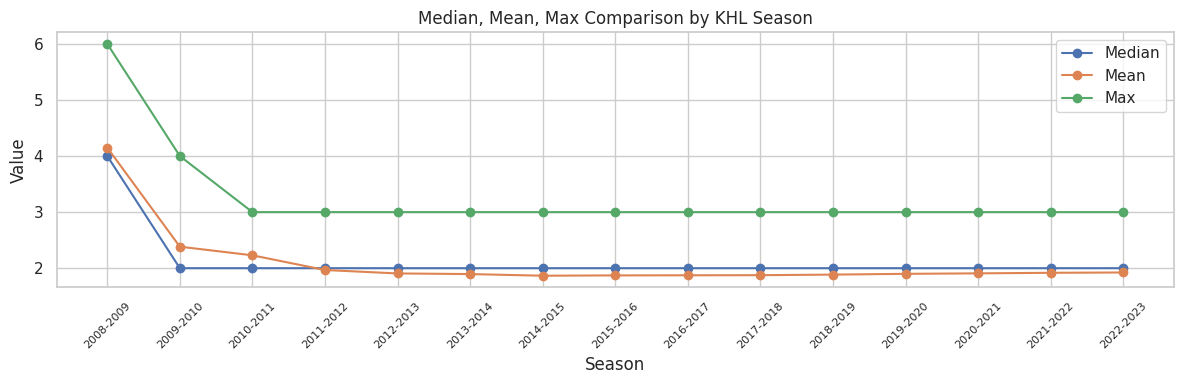

In [219]:
plt.figure(figsize=(12, 4))
plt.plot(lemtyugov_by_season['key'], lemtyugov_by_season['median'], marker='o', label='Median')
plt.plot(lemtyugov_by_season['key'], lemtyugov_by_season['mean'], marker='o', label='Mean')
plt.plot(lemtyugov_by_season['key'], lemtyugov_by_season['max'], marker='o', label='Max')

plt.xlabel('Season')
plt.ylabel('Value')
plt.title('Median, Mean, Max Comparison by KHL Season')
plt.xticks(rotation=45)
plt.gca().tick_params(axis='x', labelsize=8)  # размер меток на оси x
plt.legend()

plt.tight_layout()
plt.show()

В первом сезоне (2008-2009) между хоккеистами было меньше связей друг с другом, поэтому видим высокие значения числа Лемтюгова. Дальше близость между хоккеистами становится всё более тесной. Максимальное число Лемтюгова только в первые два сезона превышало значение 3, которое сохраняется до последнего сезона.

In [220]:
lemt_number_values_by_season = result_df[['key',
                                          'player_id_nunique',
                                          0, 1, 2, 3, 4, 5, 6]]
lemt_number_values_by_season

key  player_id_nunique  0    1     2    3    4    5   6
0   2008-2009                774  1   27     3  116  348  235  44
1   2009-2010               1029  1   73   486  468    1    0   0
2   2010-2011               1202  1   79   765  357    0    0   0
3   2011-2012               1358  1  144  1111  102    0    0   0
4   2012-2013               1614  1  202  1358   53    0    0   0
5   2013-2014               1870  1  256  1551   62    0    0   0
6   2014-2015               2078  1  311  1732   34    0    0   0
7   2015-2016               2303  1  327  1942   33    0    0   0
8   2016-2017               2513  1  343  2142   27    0    0   0
9   2017-2018               2717  1  357  2339   20    0    0   0
10  2018-2019               2902  1  357  2517   27    0    0   0
11  2019-2020               3104  1  357  2699   47    0    0   0
12  2020-2021               3352  1  357  2944   50    0    0   0
13  2021-2022               3552  1  357  3127   67    0    0   0
14  2022-2023               3720  1  357  3287   75    0    0   0

In [221]:
# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/lemt_number_values_by_season.csv'

# Сохранение датафрейма в CSV-файле
#lemt_number_values_by_season.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

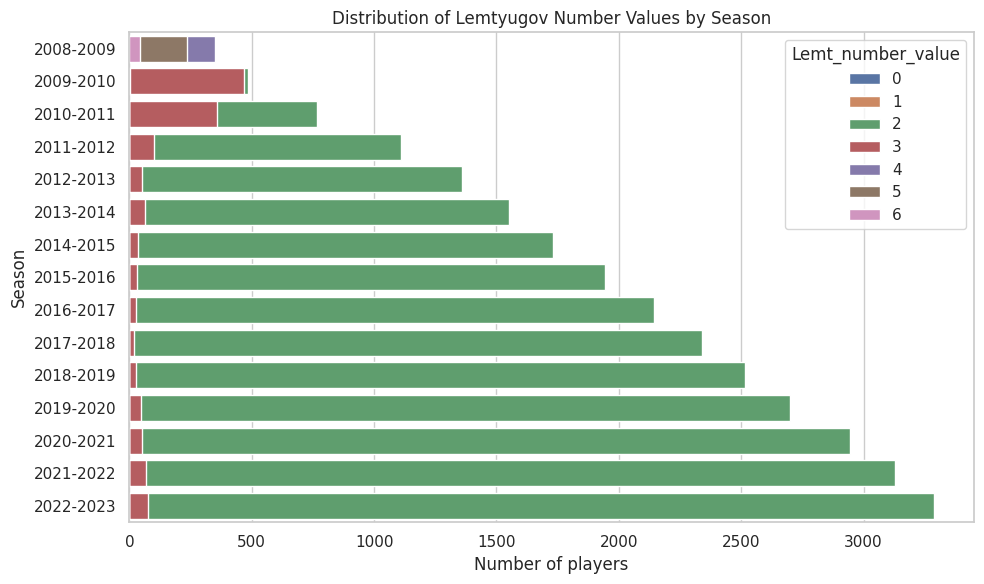

In [222]:
# Переворачиваем таблицу для удобства визуализации
melted_df = pd.melt(lemt_number_values_by_season, id_vars=['key'],
                    value_vars=[0, 1, 2, 3, 4, 5, 6],
                    var_name='Lemt_number_value',
                    value_name='Value')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Используем горизонтальную столбчатую диаграмму для визуализации распределения значений для каждой категории внутри каждого сезона
sns.barplot(x='Value', y='key', hue='Lemt_number_value', data=melted_df, dodge=False, orient='h')

plt.xlabel('Number of players')
plt.ylabel('Season')
plt.title('Distribution of Lemtyugov Number Values by Season')

plt.tight_layout()  # Улучшает распределение элементов на графике
plt.show()

Видим, что из сезона в сезон не только растет количество игроков, бывавших в Лиге, но также и увеличивается близость хоккеистов к Лемтюгову.

Построим еще один график, на котором показажем, сколько хоккеистов было в лиге по годам, и раскрасим по значению числа Лемтюгова.

In [223]:
lemt_number_values_by_season.columns = ['season', "player_id_nunique", "lemt_0", "lemt_1", "lemt_2", "lemt_3", "lemt_4", "lemt_5", "lemt_6"]

In [224]:
fig = go.Figure()
colors = ['black', 'red', 'yellow', 'green', 'purple', 'orange', 'pink']

for i, col in enumerate(lemt_number_values_by_season.columns[2:]):
    fig.add_trace(go.Scatter(
        x=lemt_number_values_by_season["season"],
        y=lemt_number_values_by_season[col],
        fill='tonexty',  # Заливка до следующей кривой
        mode='none',
        name=col,
        stackgroup='one',  # Группа для стекирования
        hoverinfo="y+name",
        line=dict(color=f"rgba({i * 30},{i * 70},{i * 100},1)")
    ))

fig.update_layout(
    title="Количество хоккеистов по сезонам с учетом числа Лемтюгова",
    xaxis=dict(title="Сезон"),
    yaxis=dict(title="Значение числа Лемтюгова"),
    xaxis_tickangle=-45,
    legend=dict(x=0, y=1, title_text="Число Лемтюгова"),
    margin=dict(l=0, r=0, t=60, b=0),
    showlegend=True,
    hovermode="x",
    width=1000,
    height=600
)

#fig.show()

Происходит рост количества игроков, растет доля игроков с числом Лемтюгова 2.

### Визуализация графов

Далее визуализируем графы. Данные за сезон '2008-2009' находятся в словаре lemtyugov_number_dataframe['2008-2009'].

In [225]:
lemtyugov_number_dataframe['2008-2009'].head()

player_id  lemtyugov_number
0     13705                 0
1     11543                 1
2     13036                 1
3     14267                 1
4      5211                 1

In [226]:
#clubmates_dataframes_dict['2008-2009']

In [227]:
# Создаем пустой граф
G = nx.Graph()

# Добавляем узлы и ребра на основе словаря
for node, neighbors in clubmates_dataframes_dict['2008-2009'].items():
    G.add_node(node)
    G.add_edges_from((node, neighbor) for neighbor in neighbors)

In [228]:
pos = nx.spring_layout(G, seed=10) #здесь позиционирование узлов

In [229]:
#задаем позицию для каждого узла
for node in G.nodes:
    G.nodes[node]['pos'] = list(pos[node])

In [230]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [231]:
# задаем позицию для каждого узла
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('player: '+str(adjacencies[0])+ ' ' + '# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [232]:
#выводим граф
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(width=800, height=800,
                title='Граф связей игроков за сезон 2008-2009',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

Аналогично визуализируем данные за следующий сезон.

⏰

In [233]:
#clubmates_dataframes_dict['2009-2010']

In [234]:
# Создаем пустой граф
G = nx.Graph()

# Добавляем узлы и ребра на основе словаря
for node, neighbors in clubmates_dataframes_dict['2009-2010'].items():
    G.add_node(node)
    G.add_edges_from((node, neighbor) for neighbor in neighbors)

pos = nx.spring_layout(G, seed=10) #здесь позиционирование узлов

#задаем позицию для каждого узла
for node in G.nodes:
    G.nodes[node]['pos'] = list(pos[node])

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [235]:
# задаем позицию для каждого узла
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('player: '+str(adjacencies[0])+ ' ' + '# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [236]:
#выводим граф
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(width=800, height=800,
                title='Граф связей игроков за сезон 2009-2010',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

## Гипотеза о связи роста/веса и количестве переходов у хоккеиста

Проверим, есть ли связь между количеством переходов и ростом/весом игрока (предполагаем, что игроки, у которых рост выше, лучше играют в хоккей и
соответственно чаще переходят из клуба в клуб).

In [237]:
players_transfers_count = players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(
    by='transfers_count')

players_transfers_count

player_id  transfers_count
1859     20929                1
1502     18939                1
1501     18938                1
2662     27320                1
1499     18936                1
...        ...              ...
3243       392               12
3601      5433               13
221      14299               13
3482      4351               14
108      13679               14

[3720 rows x 2 columns]

Количество переходов у одного хоккеиста варьируется от 1 до 14.

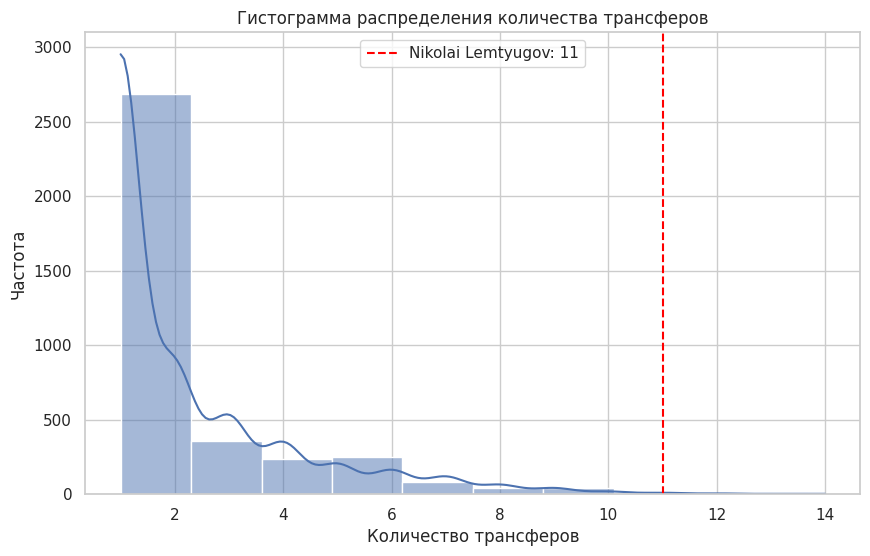

In [238]:
plt.figure(figsize=(10, 6))

sns.histplot(data=players_transfers_count,
             x='transfers_count',
             bins=10,
             kde=True)

# Особая отметка для заданного значения
special_value = players_transfers_count[players_transfers_count['player_id'] == '13705']['transfers_count'].values[0]
plt.axvline(x=special_value, color='red', linestyle='dashed', label=f'Nikolai Lemtyugov: {special_value}')
plt.legend()

plt.xlabel('Количество трансферов')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества трансферов')

plt.show()

In [239]:
find_player_id_by_name(player_dict, "Nikolai Lemtyugov")

'13705'

In [240]:
players_transfers_count[players_transfers_count['player_id']=='13705']

player_id  transfers_count
116     13705               11

In [241]:
players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(by='transfers_count')

player_id  transfers_count
1859     20929                1
1502     18939                1
1501     18938                1
2662     27320                1
1499     18936                1
...        ...              ...
3243       392               12
3601      5433               13
221      14299               13
3482      4351               14
108      13679               14

[3720 rows x 2 columns]

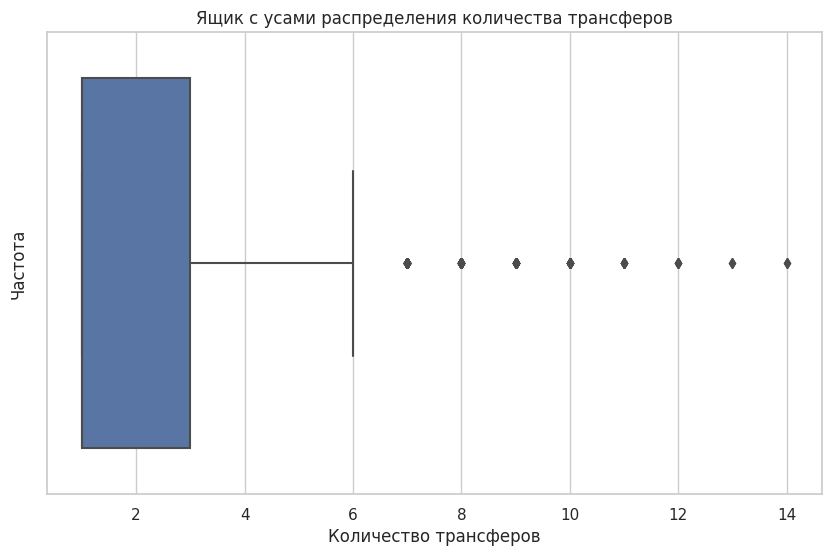

In [242]:
plt.figure(figsize=(10, 6))
transfers_count_data = players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(by='transfers_count')
sns.boxplot(x='transfers_count', data=transfers_count_data)
plt.xlabel('Количество трансферов')
plt.ylabel('Частота')
plt.title('Ящик с усами распределения количества трансферов')
plt.show()

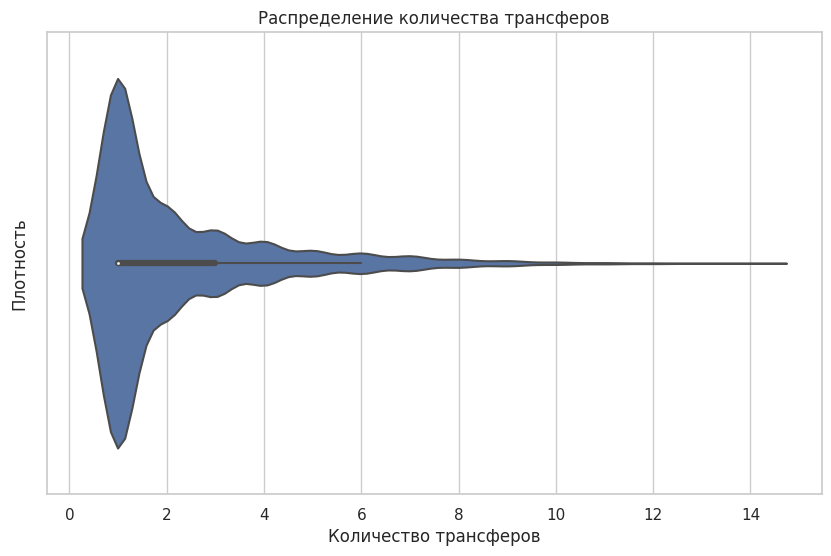

In [243]:
plt.figure(figsize=(10, 6))
transfers_count_data = players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(by='transfers_count')
sns.violinplot(x='transfers_count', data=transfers_count_data)
plt.xlabel('Количество трансферов')
plt.ylabel('Плотность')
plt.title('Распределение количества трансферов')
plt.show()

Видим, что у большинства хоккеистов не так много переходов (трансферов).

Данные о росте/ весе хоккеистов лежат в датасете stat.

In [244]:
stat.head()

player_link  \
0  https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
1  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
2  https://en.khl.ru/players/13041/?idplayer=13041&PAGEN_1=1   
3  https://en.khl.ru/players/38736/?idplayer=38736&PAGEN_1=1   
4  https://en.khl.ru/players/24998/?idplayer=24998&PAGEN_1=1   

                player    position        born age  country  hight  weight  \
0   Juhamatti Aaltonen     forward   4-июн.-85  38  Finland    184      89   
1        Miro Aaltonen     forward   7-июн.-93  30  Finland    177      84   
2  Ruslan Abdrakhmanov     forward  25-дек.-84  38   Russia    178      77   
3       Jindrich Abdul     forward  1-февр.-96  27  Czechia    185      85   
4    Ilnur Abdulkhakov  goaltender  15-янв.-99  24   Russia    187      84   

   shoot   GP  ...  TIE/G  SFTE/G  TIPP/G  SFTPP/G  TISH/G  SFTSH/G   HITS  \
0  right  245  ...  12:30      18    2:44     3,62    0:21     0,74  31.00   
1   left  256  ...  13:38   20,59    3:16     3,79    0:43      1,5 182.00   
2   left   10  ...   9:14    11,7    0:48      1,8    0:05      0,3   0.00   
3   left   12  ...  10:21   15,75    1:34     2,33    0:57     1,75   6.00   
4   left    0  ...    NaN     NaN     NaN      NaN     NaN      NaN    NaN   

     BLS   FOA  TkA  
0  17.00 22.00 0.00  
1 116.00 60.00 0.00  
2   0.00  0.00 0.00  
3   3.00  7.00 0.00  
4    NaN   NaN  NaN  

[5 rows x 41 columns]

In [245]:
stat['player_link'].nunique()

3717

In [246]:
stat["player_id"] = stat["player_link"].apply(
    lambda x: re.search(r'idplayer=(\d+)', x).group(1) if re.search(r'idplayer=(\d+)', x) else None)

In [247]:
stat['player_id'].nunique()

3717

In [248]:
del stat['player_link']

In [249]:
hight_weight_data = stat[['player_id', 'hight', 'weight']]

In [250]:
hight_weight_data

player_id  hight  weight
0        16785    184      89
1        17585    177      84
2        13041    178      77
3        38736    185      85
4        24998    187      84
...        ...    ...     ...
3712     19061    194      85
3713     16028    189      97
3714     15765    170      76
3715     16593    187      88
3716     40564    188      81

[3717 rows x 3 columns]

Объединим наши данные.

In [251]:
players_transfers_count_stats = players_transfers_count.merge(
    hight_weight_data,
    on = 'player_id')

players_transfers_count_stats

player_id  transfers_count  hight  weight
0        20929                1    187      93
1        18939                1    188      93
2        18938                1    188      93
3        27320                1    177      67
4        18936                1    180      74
...        ...              ...    ...     ...
3712       392               12    188     108
3713      5433               13    175      81
3714     14299               13    189      96
3715      4351               14    192     100
3716     13679               14    190      94

[3717 rows x 4 columns]

In [252]:
# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/players_transfers_count_stats.csv'

# Сохранение датафрейма в CSV-файле
#players_transfers_count_stats.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

In [253]:
players_transfers_count_stats[players_transfers_count_stats['player_id'] == '13705']

player_id  transfers_count  hight  weight
3706     13705               11    184      96

Посмотрим на распределения роста и веса хоккеистов.

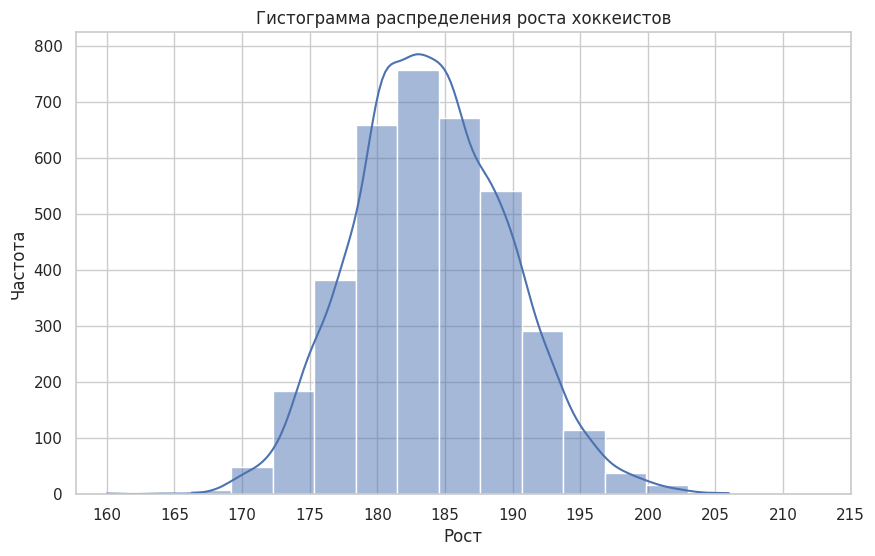

In [254]:
plt.figure(figsize=(10, 6))
sns.histplot(data=players_transfers_count_stats,
             x='hight',
             bins=15,
             kde=True)
plt.xlabel('Рост')
plt.ylabel('Частота')
plt.title('Гистограмма распределения роста хоккеистов')
plt.xticks(range(160, 220, 5), rotation=0)
plt.show()

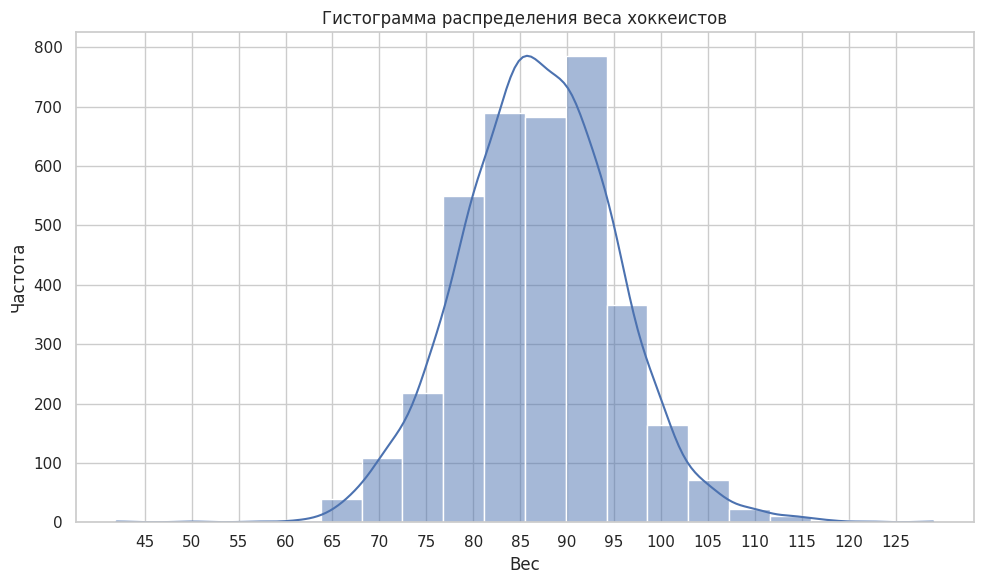

In [255]:
plt.figure(figsize=(10, 6))
sns.histplot(data=players_transfers_count_stats,
             x='weight',
             bins=20,
             kde=True)
plt.title('Гистограмма распределения веса хоккеистов')
plt.xlabel('Вес')
plt.ylabel('Частота')
plt.xticks(range(45, 130, 5), rotation=0)
plt.tight_layout()
plt.show()

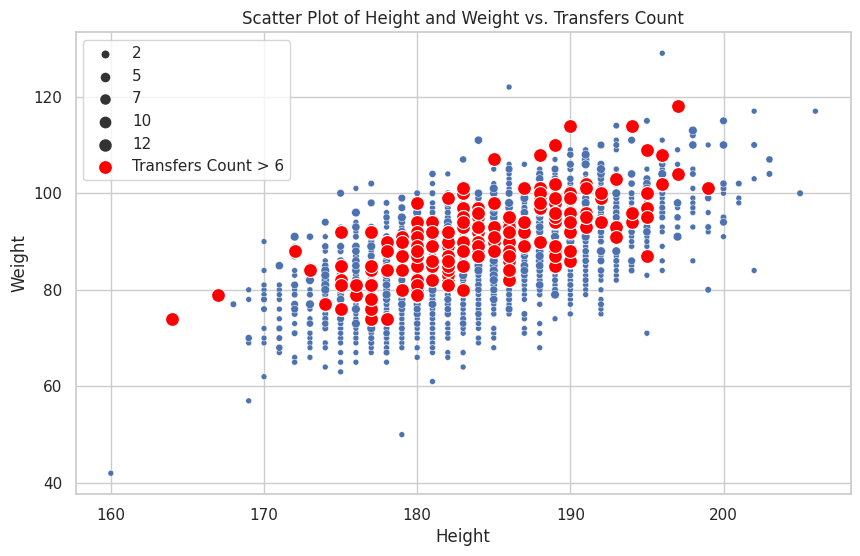

In [256]:
plt.figure(figsize=(10, 6))

# Создание scatter plot
sns.scatterplot(x='hight',
                y='weight',
                size='transfers_count',
                data=players_transfers_count_stats)

# Отметка точек с transfers_count > 6 красным цветом
sns.scatterplot(x='hight',
                y='weight',
                data=players_transfers_count_stats[players_transfers_count_stats['transfers_count'] > 6],
                color='red',
                s=100,  # Размер красных точек
                label='Transfers Count > 6')

plt.title('Scatter Plot of Height and Weight vs. Transfers Count')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

plt.show()

**Нулевая гипотеза (H0):** Между ростом хоккеистов и количеством их трансферов не существует статистически значимой корреляции.

**Альтернативная гипотеза (H1):** Существует статистически значимая корреляция между ростом хоккеистов и количеством их трансферов.

In [257]:
# Данные
hight = players_transfers_count_stats['hight']
transfers_count = players_transfers_count_stats['transfers_count']

# Вычисляем коэффициент корреляции Спирмена и p-значение
corr, p_value = stats.spearmanr(hight, transfers_count)

# Уровень значимости (alpha)
alpha = 0.05

# Определяем критическое значение для уровня значимости и количества наблюдений
critical_value = stats.t.ppf(1 - alpha, len(hight) - 2)

# Определяем границы для области отвержения нулевой гипотезы
lower_bound = -critical_value
upper_bound = critical_value

# Выводим результаты
print(f"Коэффициент корреляции Спирмена: {corr:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая корреляция")
    if corr < lower_bound:
        print("Ошибка первого рода: положительная корреляция, но отвергли")
    elif corr > upper_bound:
        print("Ошибка первого рода: отрицательная корреляция, но отвергли")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимой корреляции")
    if lower_bound < corr < upper_bound:
        print("Ошибка второго рода: не отвергли нулевую гипотезу, хотя есть корреляция")


Коэффициент корреляции Спирмена: 0.0356
P-значение: 0.0301
Отвергаем нулевую гипотезу: есть статистически значимая корреляция


**Нулевая гипотеза (H0):** Между весом хоккеистов и количеством их трансферов не существует статистически значимой корреляции.

**Альтернативная гипотеза (H1):** Существует статистически значимая корреляция между весом хоккеистов и количеством их трансферов.

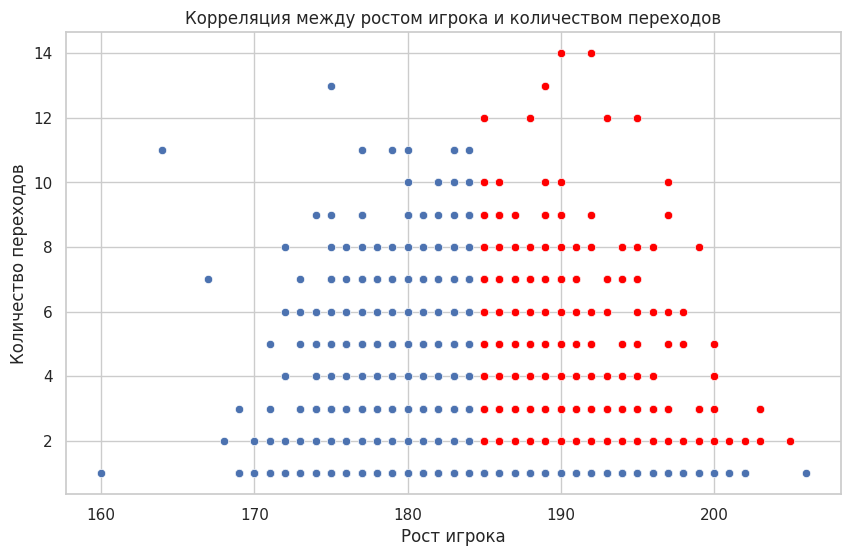

In [258]:
plt.figure(figsize=(10, 6))

# Разделяем данные на две категории: большой рост и большое количество переходов
high_weight_high_transfers = players_transfers_count_stats[
    (players_transfers_count_stats['hight'] > players_transfers_count_stats['hight'].median()) &
    (players_transfers_count_stats['transfers_count'] > players_transfers_count_stats['transfers_count'].median())
]

# Создаем scatter plot с обычными точками
sns.scatterplot(x='hight', y='transfers_count', data=players_transfers_count_stats)

# Создаем scatter plot с красными точками для игроков с большим ростом и большим количеством переходов
sns.scatterplot(x='hight', y='transfers_count', data=high_weight_high_transfers, color='red')

# Добавляем название графика и метки осей
plt.title("Корреляция между ростом игрока и количеством переходов")
plt.xlabel("Рост игрока")
plt.ylabel("Количество переходов")

# Отображаем график
plt.show()

In [259]:
# Данные
hight = players_transfers_count_stats['weight']
transfers_count = players_transfers_count_stats['transfers_count']

# Вычисляем коэффициент корреляции Спирмена и p-значение
corr, p_value = stats.spearmanr(hight, transfers_count)

# Уровень значимости (alpha)
alpha = 0.05

# Определяем критическое значение для уровня значимости и количества наблюдений
critical_value = stats.t.ppf(1 - alpha, len(hight) - 2)

# Определяем границы для области отвержения нулевой гипотезы
lower_bound = -critical_value
upper_bound = critical_value

# Выводим результаты
print(f"Коэффициент корреляции Спирмена: {corr:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая корреляция")
    if corr < lower_bound:
        print("Ошибка первого рода: положительная корреляция, но отвергли")
    elif corr > upper_bound:
        print("Ошибка первого рода: отрицательная корреляция, но отвергли")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимой корреляции")
    if lower_bound < corr < upper_bound:
        print("Ошибка второго рода: не отвергли нулевую гипотезу, хотя есть корреляция")

Коэффициент корреляции Спирмена: 0.2459
P-значение: 0.0000
Отвергаем нулевую гипотезу: есть статистически значимая корреляция


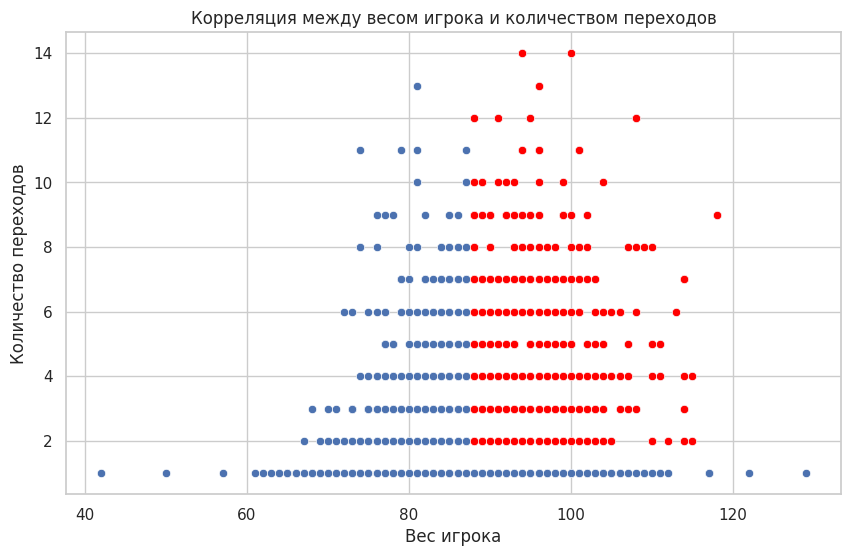

In [260]:
plt.figure(figsize=(10, 6))

# Разделяем данные на две категории: большой вес и большое количество переходов
high_weight_high_transfers = players_transfers_count_stats[
    (players_transfers_count_stats['weight'] > players_transfers_count_stats['weight'].median()) &
    (players_transfers_count_stats['transfers_count'] > players_transfers_count_stats['transfers_count'].median())
]

# Создаем scatter plot с обычными точками
sns.scatterplot(x='weight', y='transfers_count', data=players_transfers_count_stats)

# Создаем scatter plot с красными точками для игроков с большим весом и большим количеством переходов
sns.scatterplot(x='weight', y='transfers_count', data=high_weight_high_transfers, color='red')

# Добавляем название графика и метки осей
plt.title("Корреляция между весом игрока и количеством переходов")
plt.xlabel("Вес игрока")
plt.ylabel("Количество переходов")

# Отображаем график
plt.show()

Проведем также регрессионный анализ.

In [261]:
X = players_transfers_count_stats[['hight', 'weight']]
X = sm.add_constant(X)
y = players_transfers_count_stats['transfers_count']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        transfers_count   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     137.4
Date:                Wed, 16 Aug 2023   Prob (F-statistic):           2.78e-58
Time:                        16:34:50   Log-Likelihood:                -7564.0
No. Observations:                3717   AIC:                         1.513e+04
Df Residuals:                    3714   BIC:                         1.515e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2659      1.054      5.946      0.0

Анализ множественной регрессии показывает следующее:

* R-squared: 0.069 - Это коэффициент детерминации, который указывает, какая часть изменчивости зависимой переменной (количество переходов) объяснена моделью. В данном случае, модель объясняет около 6.9% вариации.

* F-statistic: 137.4 - Это значение F-статистики, которое проверяет гипотезу о том, что все коэффициенты регрессии равны нулю. Низкое p-значение (2.78e-58) указывает на то, что модель статистически значима.

* P>|t| для hight и weight: Они равны 0.000, что говорит о том, что и рост, и вес являются статистически значимыми предикторами количества переходов.

Коэффициенты:

* const (константа): 6.2659
* hight (рост): -0.0582
* weight (вес): 0.0765
* Интерпретация коэффициентов:

Константа (const) - базовое значение количества переходов при нулевых значениях роста и веса.
Коэффициент для роста (hight) - каждый дополнительный сантиметр роста связан с уменьшением количества переходов на 0.0582.
Коэффициент для веса (weight) - каждый дополнительный килограмм веса связан с увеличением количества переходов на 0.0765.
Эти результаты говорят о том, что существует статистически значимая, но относительно слабая связь между ростом, весом и количеством переходов. При этом, коэффициент детерминации (R-squared) низок, что означает, что другие факторы могут также влиять на количество переходов и не учтены в данной модели.

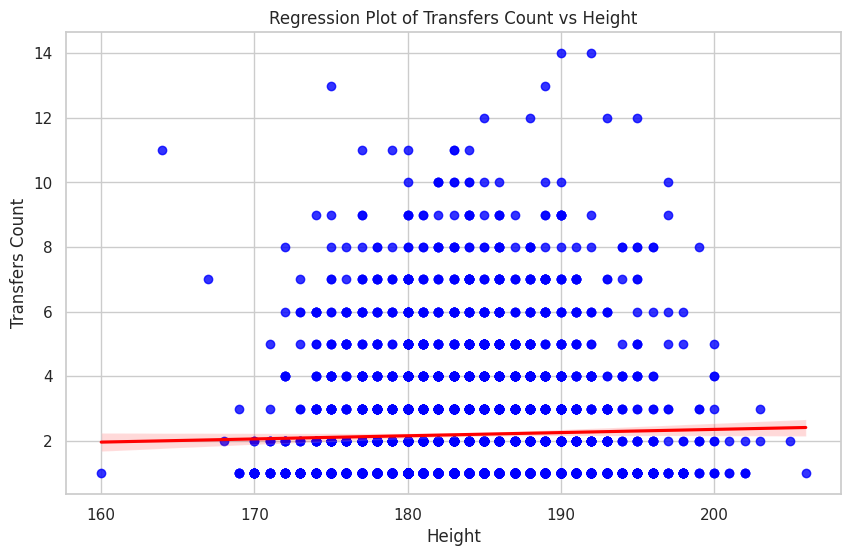

In [262]:
plt.figure(figsize=(10, 6))
sns.regplot(x='hight', y='transfers_count', data=players_transfers_count_stats, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Regression Plot of Transfers Count vs Height')
plt.xlabel('Height')
plt.ylabel('Transfers Count')
plt.show()

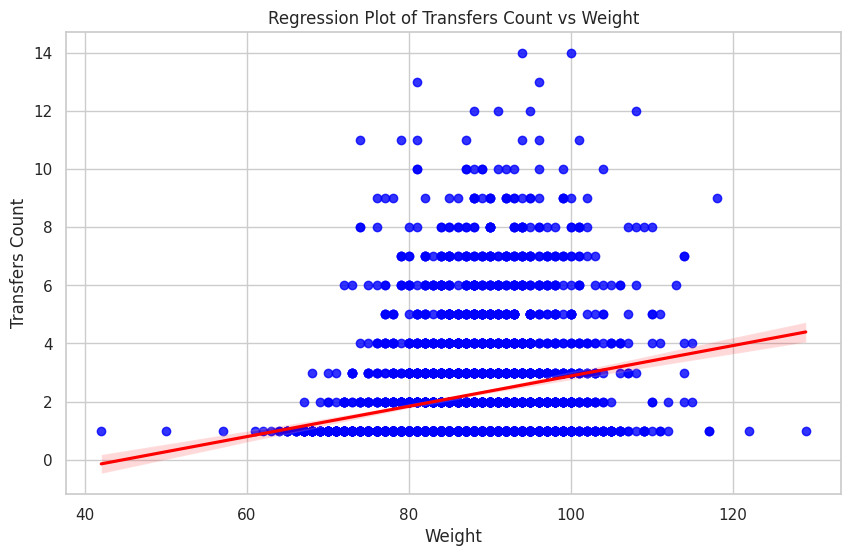

In [263]:
plt.figure(figsize=(10, 6))
sns.regplot(x='weight', y='transfers_count', data=players_transfers_count_stats, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.title('Regression Plot of Transfers Count vs Weight')
plt.xlabel('Weight')
plt.ylabel('Transfers Count')

plt.show()

Эти графики демонстрируют линию регрессии (красную линию), которая показывает тенденцию в изменении количества переходов в зависимости от роста и веса игроков. Точки на графике представляют наблюдаемые данные. Также мы могли заметить, что вес влияет на количество переходов сильнее, чем рост.

# Выводы по исследованию

Итак, в данном проекте было рассчитано число Лемтюгова - это своего рода **аналог "шести рукопожатий"** в мире хоккея, которое измеряет степень связи между хоккеистами в лиге КХЛ через команды, в которых они играли вместе с Николаем Лемтюговым. По состоянию на 2023 г., **макисмальное число Лемтюгова - 3**, то есть хоккеисты лиги КХЛ знакомы друг с другом максимум через 3 рукопожатия.  Если максимальное число Лемтюгова равно 3, это означает, что два случайных хоккеиста в лиге КХЛ, даже если они никогда не играли в одной команде с Лемтюговым, могут быть связаны цепочкой общих команд через других хоккеистов, где каждый последующий хоккеист играл с кем-то, кто играл с Лемтюговым. Это интересная концепция, которая демонстрирует, как **мир спорта может быть связан через относительно небольшое количество связей**. Такие метрики помогают наглядно представить, насколько сильно переплетено хоккейное сообщество и как близки могут быть взаимоотношения между игроками.

Также в проекте были проверены некоторые гипотезы.
*   **Количество одноклубников.** Была проверена гипотеза о популярности Николая Лемтюгова как хоккеиста с самым большим количеством одноклубников в лиге КХЛ. Однако оказалось, что у некоторых других игроков количество одноклубников больше, чем у Лемтюгова. У Лемтюгова 357 одноклубников, но есть хоккеисты с числом одноклубников, достигающим 475. Таким образом, гипотеза оказалась неверной. Проект показал, что хотя у Лемтюгова действительно много одноклубников и он имеет относительно большое количество связей через команды, в которых он играл, он не обладает максимальным количеством одноклубников в лиге КХЛ. Это интересное наблюдение, которое подчеркивает сложность и разнообразие взаимосвязей в мире хоккея.


*   **Количество команд.** Проведенное исследование показало статистически значимые различия между средними значениями количества команд, в которых играли хоккеисты, в зависимости от значения числа Лемтюгова. Количество команд, в которых играли хоккеисты, действительно различается в зависимости от числа Лемтюгова. Игроки с низким значением числа Лемтюгова играли в среднем в большем количестве команд, чем игроки, у которых это значение больше.

*   **Все связаны друг с другом.** Все игроки в нашем исследовании имеют какие-либо связи через других игроков (то есть через команды, в которых они играли), то следовательно, число Лемтюгова для каждого игрока в этой выборке не будет отсутствовать. Число Лемтюгова присутствует у всех игроков в выборке.

*   **Медианное значение числа Лемтюгова** равно 2. Это означает, что медианное расстояние в числе рукопожатий, которое связывает хоккеистов лиги КХЛ через команды, в которых они играли, с Николаем Лемтюговым, составляет два. Это интересный результат, который указывает на то, что большинство хоккеистов имеют относительно близкую связь с Лемтюговым через других игроков и команды.

*   Было также рассчитано **число Лемтюгова по сезонам** с начала существования КХЛ. В первом сезоне (2008-2009) между хоккеистами было меньше связей друг с другом, поэтому видим высокие значения числа Лемтюгова. Это можно объяснить тем, что на старте лиги КХЛ у игроков было меньше возможностей играть вместе, что приводило к более длинным цепочкам связей через других игроков. По мере развития лиги и увеличения числа сезонов связи между хоккеистами становились более тесными, что отражается в снижении значения числа Лемтюгова. Важно, что максимальное число Лемтюгова начинает превышать 3 только в первые два сезона, а затем остается на уровне 3, что говорит о том, что игроки в целом становились все ближе друг к другу в течение последующих сезонов. Это наблюдение подчеркивает, как социальные и карьерные связи между хоккеистами могли эволюционировать и укрепляться в течение истории лиги КХЛ.

*   Мы провели статистический анализ, чтобы определить, есть ли **связь между ростом/весом хоккеистов и количеством их трансферов**.  Результаты данного исследования подтвердили, что существует статистически значимая корреляция между исследуемыми физическими характеристиками игроков и частотой их переходов. Коэффициент корреляции для роста был относительно невысок (0.0356), что может говорить о слабой связи между ростом хоккеистов и частотой переходов. Однако, он был статистически значим, что означает, что даже слабая корреляция может быть интерпретирована как свидетельство наличия взаимосвязи. С другой стороны, коэффициент корреляции для веса был значительно выше (0.2459), что указывает на более сильную связь между весом игроков и частотой их трансферов. Высокое p-значение  говорит о том, что вероятность случайной корреляции практически нулевая, подтверждая статистическую значимость. Такие результаты можно объяснить следующим образом: физические характеристики игроков, такие как рост и вес, могут оказывать влияние на их игровую производительность. Более высокий рост и вес могут давать преимущества в некоторых аспектах игры, таких как силовые схватки, защита и атака. Это, в свою очередь, может влиять на интерес со стороны различных клубов, что может обусловить более частые переходы для игроков с определенными физическими характеристиками. Таким образом, исследование позволяет сделать вывод о наличии связи между ростом/весом хоккеистов и количеством их трансферов, что может указывать на важность этих факторов в карьере и игровой активности хоккеистов.